# Philadelphia Housing Model—Technical Appendix

Predicting Residential Property Prices

Ming Cao, Mark Deng, Jun Luu, Josh Rigsby, Alex Stauffer, Tess Vu

# Data Cleaning

## Primary Philadelphia Sales Data (OpenDataPhilly)

In [ ]:
# Import relevant libraries.
library(car)

Loading required package: carData


Attaching package: 'dplyr'

The following object is masked from 'package:car':

    recode

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

Linking to GEOS 3.13.1, GDAL 3.11.0, PROJ 9.6.0; sf_use_s2() is TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ purrr     1.1.0
✔ lubridate 1.9.4     ✔ readr     2.1.5

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor()      masks scales::col_factor()
✖ gridExtra::combine()     masks dplyr::combine()
✖ purrr::discard()         masks scales::discard()
✖ dplyr::filter()          masks stats::filter()
✖ kableExtra::group_rows() masks dplyr::group_rows()
✖ dplyr::lag()             masks stats::lag()
✖ dplyr::recode()          masks car::recode()
✖ purrr::some()            masks car::some()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

udunits database from C:/Users/Tess/AppData/Local/R/win-library/4.5/units/share/udunits/udunits2.xml

In [ ]:
# Property data.
properties_path <- "data/philly_properties.csv"
properties <- read.csv(properties_path)

# Capture dimensions.
og_property_dimension <- dim(properties)

# Set Census API key.
census_api_key("3aaee31789e10b674a531e9f236c35d5394b19ed")

To install your API key for use in future sessions, run this function with `install = TRUE`.

In [ ]:
# All variables are character strings, remove white space then convert numeric character variables to numeric classes for chosen variables.

properties <- properties %>%
  mutate(across(where(is.character), str_trim),
         across(c(fireplaces, garage_spaces, number_of_bathrooms, number_stories,
                  sale_price, total_livable_area, year_built), as.numeric)) %>%
  rename(fireplace_num = fireplaces,
         garage_num = garage_spaces,
         bath_num = number_of_bathrooms,
         story_num = number_stories,
         square_feet = total_livable_area,
         basement_type = basements,
         ac_binary = central_air,
         fuel_type = fuel,
         )

The first warning was:
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.

In [ ]:
# Filter to residential properties and 2023-2024 sales.
# Note: Category code #1 is for residential.
residential_prop <- properties %>%
  filter(.,
         category_code == 1,
         startsWith(sale_date, "2023") | startsWith(sale_date, "2024"))

# Drop empty variables or variables not needed for model.
residential_prop <- residential_prop %>%
  select(c(basement_type, ac_binary, fireplace_num, fuel_type, garage_num,
           bath_num, story_num, sale_date, sale_price,
           square_feet, year_built, shape)
         )

# Make empty character column values NA.
residential_prop <- residential_prop %>%
  mutate(across(where(is.character), ~na_if(., "")))

In [ ]:
# Drop prices that are less than $10,000 as a catch-all (might not be as reflective for rural areas). Avoiding dropping prices based on percent of assessed value since property assessments can be biased against minoritized communities. Ideal drop would add deed type to drop any family or forced transfers.
residential_prop <- residential_prop %>%
  filter(sale_price > 10000,
         square_feet > 0)

In [ ]:
# Create building age column, change central air to binary, and adjust basement and fuel types.
# Create log value for the sale price.
residential_prop <- residential_prop %>%
  mutate(ln_sale_price = log(sale_price),
         age = 2025 - year_built,
         ln_square_feet = log(square_feet),
         ac_binary = case_when(
           ac_binary == "Y" ~ 1,
           ac_binary == "N" ~ 0),
         basement_type = case_when(
           basement_type == "0" ~ "None",
           basement_type == "A" ~ "Full Finished",
           basement_type == "B" ~ "Full Semi-Finished",
           basement_type == "C" ~ "Full Unfinished",
           basement_type == "D" ~ "Full Unknown Finish",
           basement_type == "E" ~ "Partial Finished",
           basement_type == "F" ~ "Partial Semi-Finished",
           basement_type == "G" ~ "Partial Unfinished",
           basement_type == "H" ~ "Partial Unknown Finish",
           basement_type == "I" ~ "Unknown Size Finished",
           basement_type == "J" ~ "Unknown Size Unfinished"),
         fuel_type = case_when(
           fuel_type == "A" ~ "Natural Gas",
           fuel_type == "B" ~ "Oil Heat",
           fuel_type == "C" ~ "Electric",
           fuel_type == "D" ~ "Coal",
           fuel_type == "E" ~ "Solar",
           fuel_type == "F" ~ "Wood",
           fuel_type == "G" ~ "Other",
           fuel_type == "H" ~ "None")
         )

In [ ]:
# Turn categorical data into factors so OLS regression doesn't handle the data as a list of strings.
residential_prop$basement_type <- as.factor(residential_prop$basement_type)
residential_prop$fuel_type <- as.factor(residential_prop$fuel_type)

# Change the reference categories for baseline comparison.
residential_prop$basement_type <- relevel(residential_prop$basement_type, ref = "None")
residential_prop$fuel_type <- relevel(residential_prop$fuel_type, ref = "Natural Gas")

# Place fuel type with 10 or less counts into other category.
residential_prop <- residential_prop %>%
  mutate(fuel_type = fct_lump_min(fuel_type, min = 11, other_level = "Other"))

In [ ]:
# Fixed effect temporal market fluctuations. Based on sale date, splitting the years into quarters (Q1, Q2, Q3, Q4). Potential fixed effect.
residential_prop <- residential_prop %>%
  mutate(
    quarters_fe = quarter(as_datetime(sale_date))
    )

# Make it a factor.
residential_prop$quarters_fe <- factor(residential_prop$quarters_fe)

In [ ]:
# Capture dimensions.
after_property_dimension <- dim(residential_prop)

# Convert residential property to geodataframe. Use EPSG 2272 for South Pennsylvania in feet.
# Drop shape when finished creating geometry.
residential_prop_gdf <- residential_prop %>%
  mutate(geometry = st_as_sfc(shape)) %>%
  st_as_sf(crs = 2272) %>%
  rename(geometry_point = geometry) %>%
  select(-c(shape))

# Spatial Data and Feature Engineering

## Spatial Data (OpenDataPhilly)

In [ ]:
# Read in Philadelpha census tracts.
philly_tracts_path <- "data/philly_tracts/philly_tracts.shp"
philly_tracts <- st_read(philly_tracts_path)

Reading layer `philly_tracts' from data source 
  `C:\Users\Tess\Desktop\UPenn\UPenn_FW25\MUSA_5080-401_Public_Policy_Analytics\MUSA5080-Assignment3\data\philly_tracts\philly_tracts.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3446 features and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -80.51985 ymin: 39.7198 xmax: -74.68956 ymax: 42.51607
Geodetic CRS:  NAD83

           used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells  8657014 462.4   14752092  787.9  10720392  572.6
Vcells 73507245 560.9  142557851 1087.7 142557724 1087.7

In [ ]:
# Proximity to downtown.

# Decided on Euclidean distance because network proximity computation is demanding on thousands of points, even with parallel programming.

# Create single Center City point feature based on City Hall coordinates.
center_city <- st_sfc(st_point(c(-75.163500, 39.952800)), crs = 4326) %>%
  st_transform(crs = 2272)

# Need to add mile units for operations. Then remove units object for easier plotting.
residential_points$city_dist_mi <- (st_distance(residential_points, st_union(center_city))) %>%
  set_units("mi") %>%
  drop_units() %>%
  as.numeric()

# Log transform because distance benefit diminishes, for potential use.
residential_points$ln_city_dist <- log(residential_points$city_dist_mi + 0.1)

In [ ]:
# Transit proximity.
# Major cities could be distance to nearest transit like metro/rail stations, but suburban and rural areas might be better served by distance to nearest major highway.
# Read in SEPTA stops.
septa_stops_path <- "data/septa_stops.csv"

septa_stops_df <- read.csv(septa_stops_path)

# Make csv a geodataframe.
septa_stops <- septa_stops_df %>%
  st_as_sf(., coords = c("Lon", "Lat"), crs = 4326)

# Match CRS.
septa_stops <- septa_stops %>%
  st_transform(., crs = 2272)

# Stops are duplicated for the same station because the data includes directions for all cardinal directions as well as bus, rail, and trolley for the same location. This means a single station could have more than one point representing a single location residents go to commute.
# Create new column with stop name without the cardinal suffixes and keep only the unique station values.
septa_stops <- septa_stops %>%
  mutate(stations = if_else(
    str_detect(StopAbbr, "NO$|SO$|EA$|WE$|NE$|NW$|SE$|SW$"),
    str_sub(StopAbbr, end = -3),
    str_sub(StopAbbr)
    )
  ) %>%
  distinct(stations, .keep_all = TRUE)

# Create buffer zone for stops within a half mile. This is ~10 minute walk, depending on topography.
# Note: EPSG 2272 is measured in feet, not miles.
septa_distance <- st_buffer(residential_points, 2640)

# Create number of stops in the buffer zone.
septa_stations <- st_intersects(septa_distance, septa_stops)

# Append buffer zone counts and put into main tract data. Create a logged version for potential use as well because distance benefit tapers off.
residential_points <- residential_points %>%
  mutate(
    septa_half_mi = lengths(septa_stations),
    ln_septa_half_mi = log(septa_half_mi + 0.1)
  )

In [ ]:
# Park proximity / size. Measuring distance is important for accessibility, but the size of the park often matters because a property near a block-sized pocket of green space is not equivalent to being near a large one like Wissahickon Valley Park.

# Read in geojson data.
parks_path <- "data/parks.geojson"

parks <- st_read(parks_path)

Reading layer `parks' from data source 
  `C:\Users\Tess\Desktop\UPenn\UPenn_FW25\MUSA_5080-401_Public_Policy_Analytics\MUSA5080-Assignment3\data\parks.geojson' 
  using driver `GeoJSON'
Simple feature collection with 63 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -75.2837 ymin: 39.87048 xmax: -74.95865 ymax: 40.13191
Geodetic CRS:  WGS 84

In [ ]:
# Convenience/Food points of interest. Using kNN to measure the density of these amenities rather than nearest amenity point.
amenities_path <- "data/osm_pois/osm_pois.shp"
amenities <- st_read(amenities_path)

Reading layer `osm_pois' from data source 
  `C:\Users\Tess\Desktop\UPenn\UPenn_FW25\MUSA_5080-401_Public_Policy_Analytics\MUSA5080-Assignment3\data\osm_pois\osm_pois.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 65127 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -80.52111 ymin: 39.71816 xmax: -74.69473 ymax: 42.25797
Geodetic CRS:  WGS 84

In [ ]:
# k-Nearest Neighbors (kNN) function.
knn_distance <- function(distance_matrix, k) {
  apply(distance_matrix, 1, function(distances){
    mean(as.numeric(sort(distances)[1:k]))
  })
}

# Create kNN feature for amenities. k = 4 to balance for urban and suburban areas, probably not as representative of rural areas.
residential_points <- residential_points %>%
  mutate(
    knn_amenity_mi = as.numeric(knn_distance(amenities_matrix, k = 4))
  )

# Convert to miles.
residential_points$knn_amenity_mi <- as.numeric(residential_points$knn_amenity_mi / 5280)

In [ ]:
# Fixed effect neighborhoods.
neighborhoods_path <- "data/philadelphia_neighborhoods/philadelphia_neighborhoods.shp"
philly_neighborhoods <- st_read(neighborhoods_path)

Reading layer `philadelphia_neighborhoods' from data source 
  `C:\Users\Tess\Desktop\UPenn\UPenn_FW25\MUSA_5080-401_Public_Policy_Analytics\MUSA5080-Assignment3\data\philadelphia_neighborhoods\philadelphia_neighborhoods.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 159 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -75.28026 ymin: 39.86701 xmax: -74.95576 ymax: 40.13799
Geodetic CRS:  WGS 84

In [ ]:
# Capture spatial feature dimensions.
after_feat_eng_dimension <- dim(residential_points)

In [ ]:
# Spatial feature creation table, select spatial features into a separate data frame and drop geometry.
spatial_feature_df <- residential_points %>%
  select(c(city_dist_mi, ln_city_dist, septa_half_mi, ln_septa_half_mi,
           parks_mile, ln_park_dist, knn_amenity_mi)) %>%
  na.omit(.) %>%
  st_drop_geometry()

# Create a tibble from the selected spatial features.
spatial_summary <- tibble(
  "Spatial Features" = names(spatial_feature_df),
  "Description" = c("Distance from city (mi).", "Log of distance from city.", "Within 0.5mi of SEPTA station.",
                    "Log of 0.5 SEPTA station.", "Distance from nearest park (mi).",
                    "Log of distance from nearest park.", "k-Nearest Neighbors convenience and food amenities.")
)

# Make Kable of spatial features.
spatial_kable <- kable(spatial_summary,
                       caption = "Feature Engineered Variables",
                       format.args = list(big.mark = ",")
) %>%
  kable_styling(latex_options = "striped",
                full_width = FALSE) %>%
  column_spec(1, bold = TRUE, width = "5cm") %>%
  row_spec(0, color = "#f5f4f0", background = "#ff4100", bold = TRUE)

spatial_kable

  Spatial Features   Description
  ------------------ -----------------------------------------------------
  city_dist_mi       Distance from city (mi).
  ln_city_dist       Log of distance from city.
  septa_half_mi      Within 0.5mi of SEPTA station.
  ln_septa_half_mi   Log of 0.5 SEPTA station.
  parks_mile         Distance from nearest park (mi).
  ln_park_dist       Log of distance from nearest park.
  knn_amenity_mi     k-Nearest Neighbors convenience and food amenities.

  : Feature Engineered Variables


**Primary:**

From the CSV, we are analyzing the conditions of basements, number of
fireplaces, garage spaces, number of bathrooms, number of stories, the
total livable area in square feet, the existence of central air, and
type of fuel used on the property. We filtered residential category code
with the sale dates between 2023 and 2024. We eliminated property prices
\<10k. Rather than adhering to the percentage of assessed value as a
guide for this filter, for it could incorporate marginalized bias,
filtering the property prices removes non-market transactions but still
incorporates a wide diversity of communities.

The forced the central air characteristic to become binary rather than
“Y” and “N” and made sure to turn the categorical data to factors. The
reference categories for types of basements is “None” and for fuel type,
it’s “Natural Gas”. We including a building age category computed from
the year built data. We logged the square footage and the sale price to
correct for right-skewedness.

**Spatial:**

We inserted the Philadelphia census tracts, changing the CRS to 2272,
the ideal projection for SE Pennsylvania analysis. We decided to perform
a log transformation on the following variables - city_dist (distance
from City Hall in Center City), septa_half_mi (half mile buffer zone
from all septa stops within the city geometry), and parks_dist (distance
to edge of nearest park in miles) - because their effects on housing
prices were non-linear. This transformation ensures that changes in
proximity are measured more consistently across the range of distances,
rather than being dominated by properties very close to these features.

Regarding amenities, we used k-NN (k nearest neighbors) to measure the
density of amenity accessibility rather than individual point data. The
amenities are as follows: ATM, bakery, bank, bar, beauty shop,
biergarten, bookshop, butcher, café, convenience, department store, fast
food, food court, greengrocer, hairdresser, kiosk, laundry, marketplace,
pharmacy, mall, pub, restaurant, supermarket. We filtered by convenience
and food, transformed the CRS to 2272 for consistency, and then
developed a matrix. The distance was inverted, log-transformed to
account for diminishing returns, and scaled it to produce a single
numeric value in which higher, positive values indicate greater
accessibility to amenities.

We included neighborhoods as fixed effects to help explain unknown,
unquantifiable factors like cultural atmosphere and other
neighborhood-specific factors we cannot statistically account for that
may influence housing prices. It was converted into a factor so each
neighborhood can receive its own baseline model. Fiscal quarters were
also introduced as fixed effects; splitting a year into 4 quarters for
unknown factors when it comes to purchasing property (e.g. people are
more likely to buy real estate in spring and summer).

### Census Data (TidyCensus)

In [ ]:
# Open tidycensus data. Using 2023 data, because we are looking at sales 2023-2024
acs_vars <- load_variables(2023, "acs5", cache = TRUE)

# Get acs dimensions.
og_acs_dimension <- dim(acs_vars)

# The variables that we want from tidycensus
variables <- c(
  median_household_income = "B19013_001",
  total_pop = "B01003_001",
  poverty_white = "B17001A_001", # To get poverty percentage
  poverty_black = "B17001B_001",
  poverty_native = "B17001C_001",
  poverty_asian = "B17001D_001",
  poverty_islander = "B17001E_001",
  poverty_other = "B17001F_001",
  poverty_multiracial = "B17001G_001",
  male_18_24_bach = "B15001_009", # Tracts only show bachelor's degrees, unless we want to look at only people 25+
  male_25_34_bach = "B15001_017",
  male_35_44_bach = "B15001_025",
  male_45_64_bach = "B15001_033",
  male_65plus_bach = "B15001_041",
  female_18_24_bach = "B15001_050",
  female_25_34_bach = "B15001_058",
  female_35_44_bach = "B15001_066",
  female_45_64_bach = "B15001_074",
  female_65plus_bach = "B15001_082",
  total_vacant = "B25005_001", # To get vacancy percentage
  white_total_units = "B25032A_001", # Need total units to get percentage of single, detached units and vacant units.
  white_single_family = "B25032A_002",
  black_total_units = "B25032B_001",
  black_single_family = "B25032B_002",
  native_total_units = "B25032C_001",
  native_single_family = "B25032C_002",
  asian_total_units = "B25032D_001",
  asian_single_family = "B25032D_002",
  islander_total_units = "B25032E_001",
  islander_single_family = "B25032E_002",
  other_total_units = "B25032F_001",
  other_single_family = "B25032F_002",
  multiracial_total_units = "B25032G_001",
  multiracial_single_family = "B25032G_002",
  medhhinc_white = "B19013A_001", # Median Household Income
  medhhinc_black = "B19013B_001",
  medhhinc_native = "B19013C_001", 
  medhhinc_asian = "B19013D_001", 
  medhhinc_other = "B19013F_001",  # There is no tract data for native hawiian/pacific islander, I'm including it with other
  medhhinc_multiracial = "B19013G_001", 
  white_pop = "B01001A_001",
  black_pop = "B01001B_001",
  native_pop = "B01001C_001",
  asian_pop = "B01001D_001",
  islander_pop = "B01001E_001",
  other_pop = "B01001F_001",
  multiracial_pop = "B01001G_001"
)

# We are grouping our data by tracts
philly_tract_acs <- get_acs(
  geography = "tract",
  state = "PA",
  variables = variables,
  year = 2022,
  survey = "acs5",
  cache_table = TRUE, 
  output = "wide"
)

Getting data from the 2018-2022 5-year ACS

In [ ]:
# Summing up the variables that we need to create our percentage variables
philly_tract_acs <- philly_tract_acs %>%
  mutate(
    total_poverty = poverty_whiteE + poverty_blackE + poverty_nativeE + poverty_asianE + poverty_islanderE + poverty_otherE + poverty_multiracialE, # Adding all poverty populations together 
    
    total_bach = male_18_24_bachE + male_25_34_bachE + male_35_44_bachE + male_45_64_bachE + male_65plus_bachE + female_18_24_bachE + female_25_34_bachE + female_35_44_bachE + female_45_64_bachE + female_65plus_bachE, #Adding all bachelors degrees together
    
    total_units = white_total_unitsE + black_total_unitsE + native_total_unitsE + asian_total_unitsE + islander_total_unitsE + other_total_unitsE + multiracial_total_unitsE, # Total housing units
    
    total_single_family = white_single_familyE + black_single_familyE + native_single_familyE + asian_single_familyE + islander_single_familyE + other_single_familyE + multiracial_single_familyE # Total single family homes
  )

In [ ]:
# Creating our variables that we are going to analyze
philly_tract_acs <- philly_tract_acs %>%
  mutate(
    pct_poverty = (total_poverty/total_popE)*100, # Divide total poverty population by total population

    pct_bach = (total_bach/total_popE)*100, # Divide bachelor degree holders by total population
    
    pct_vacant = (total_vacantE/total_units)*100, # Divide vacant units by total housing units
    pct_vacant = ifelse(is.infinite(pct_vacant) | total_vacantE > total_units, 100, pct_vacant), # Fixing errors when units equal zero or high MOE
    
    pct_single_family = (total_single_family/total_units)*100, # Divide single family homes by total housing units
    
    medhhinc = 
  (ifelse(is.na(medhhinc_whiteE), 0, medhhinc_whiteE) * white_popE +
   ifelse(is.na(medhhinc_blackE), 0, medhhinc_blackE) * black_popE +
   ifelse(is.na(medhhinc_nativeE), 0, medhhinc_nativeE) * native_popE +
   ifelse(is.na(medhhinc_asianE), 0, medhhinc_asianE) * asian_popE +
   ifelse(is.na(medhhinc_otherE), 0, medhhinc_otherE) * (islander_popE + other_popE) +
   ifelse(is.na(medhhinc_multiracialE), 0, medhhinc_multiracialE) * multiracial_popE) / total_popE)
# For median household income, I had to turn all median household incomes that were NA to 0, so that it would not mess up the formula. 
# Multiplying median household income times population by race. There was no islander median household income, so I included it in other. All divided by the total population, to get the total median household income. 

In [ ]:
# Creating a summary table 
philly_acs_summary <- philly_tract_acs %>%
  select(
    GEOID, 
    NAME,
    pct_poverty,
    pct_bach,
    pct_vacant,
    pct_single_family,
    medhhinc
  )

# Get after acs dimension.
after_acs_dimension <- dim(philly_acs_summary)

In [ ]:
# Join primary and census data.
final_data <- residential_points %>%
  left_join(philly_acs_summary, by = "GEOID") %>%
  select(-c(sale_date, year_built, ALAND, AWATER,
            INTPTLAT, INTPTLON, NAME.x, LISTNAME, NAME.y,
            Shape_Leng, Shape_Area)
         )

In [ ]:
# Create key variables list.
key_columns <- c("sale_price", "ln_sale_price", "square_feet", "ln_square_feet",
                 "bath_num", "fireplace_num", "garage_num", "ac_binary",
                 "story_num", "age", "city_dist_mi", "ln_city_dist",
                 "septa_half_mi", "ln_septa_half_mi", "parks_mile", "ln_park_dist",
                 "knn_amenity_mi", "pct_poverty", "pct_bach",
                 "pct_vacant", "pct_single_family", "medhhinc",
                 "basement_type", "fuel_type", "neighborhood_fe", "quarters_fe")

# Reorder for key columns first and drop all rows with NA because OLS needs complete observations.
final_data <- final_data %>%
  select(any_of(key_columns), everything()) %>%
  na.omit(.)

# Get final dimension.
final_dimension <- dim(final_data)

In [ ]:
# Separate before/after dimensions for data.
dimensions <- data.frame(
  rows_columns = c("Rows", "Columns"),
  "Property Data Before" = og_property_dimension,
  "Property Data After" = after_property_dimension,
  "Property Data After Feature Engineering" = after_feat_eng_dimension,
  "ACS Data Before" = og_acs_dimension,
  "ACS Data After" = after_acs_dimension,
  "Final Data" = final_dimension
)

# Make Kable of dimensions.
dimensions_kable <- kable(dimensions,
                          col.names = c("Dimensions", "Property Data Before", "Property Data After",
                                        "Property Data After Feature Engineering",
                                        "ACS Data Before", "ACS Data After", "Final Data"),
                          digits = 2,
                          caption = "Before and After Data Dimensions",
                          format.args = list(big.mark = ",")
) %>%
  kable_styling(latex_options = "striped",
                full_width = FALSE) %>%
  column_spec(1, bold = TRUE) %>%
  row_spec(0, color = "#f5f4f0", background = "#ff4100", bold = TRUE)

dimensions_kable

  Dimensions     Property Data Before   Property Data After   Property Data After Feature Engineering   ACS Data Before   ACS Data After   Final Data
  ------------ ---------------------- --------------------- ----------------------------------------- ----------------- ---------------- ------------
  Rows                        559,322                26,344                                    13,884            28,261            3,446       13,883
  Columns                          79                    16                                        33                 4                7           28

  : Before and After Data Dimensions


**Census:**

Using tidycensus, we imported all variables that aligned with our
structural data from 2023 ACS data by tracts: median household income,
total population, poverty by ethnicity (White, Black, Native American,
Asian, Pacific Islander, “Other,” Multiracial), males and females aged
18–65+ with bachelor’s degrees or higher, total vacancy, and total
housing units by ethnicity, as well as single-family households and
median household income per ethnic group. We compiled the individual
poverty, bachelor’s degree, unit, and single-family household counts by
ethnicity to form the following percentage variables: total_poverty,
total_bach, total_units, and total_single_family.

From this, we calculated pct_poverty, pct_bach, pct_vacant (accounting
for ACS errors), pct_single_family, and medhhinc, transforming NAs to 0
for regression analysis.

Using our residential property vector data (which includes structural,
spatial, and feature-engineered variables), we performed a left join on
the cleaned ACS summary data by GEOID.

After organizing the final dataset so key variables appear first, we
generated a kable summarizing the workflow. The final dataset contains
26,344 observations and 29 columns.

# Exploratory Data Analysis (EDA)

### Visualizations

ℹ Please use the `linewidth` argument instead.

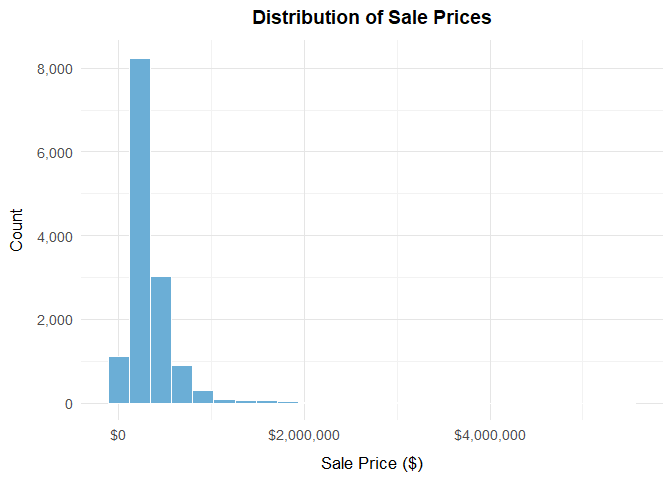

In [ ]:
# Distribution of Sale Prices Histogram

sale_price_hist <- ggplot(final_data, aes(x = sale_price)) +
  geom_histogram(fill = "#6BAED6", color = "white", bins = 25) +
  labs(title = "Distribution of Sale Prices",
       x = "Sale Price ($)",
       y = "Count") +
  scale_x_continuous(labels = scales::dollar) +
  scale_y_continuous(labels = scales::comma) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.major = element_line(color = "gray90", size = 0.3),
    panel.grid.minor = element_line(color = "gray95", size = 0.2),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
    )

**Distribution of Sales Prices - Histogram**

The distribution of sales prices is heavily skewed right, with a high
percentage of thee transactions below \$500,000, and a relatively small
number of homes falling in the multi-million dollar range. This chart
also also gives insight into the potential presence of high leverage
outliers falling toward the left. A concentration of thousands of sales
clustered on the lower end of the price ranges suggests strong
segmentation, meaning that the market is split into distinct groups,
where you see a large cluster of homes that are relatively similar and a
smaller but very different cluster of high-value properties with luxury
features and few homes in-between, the market looks like separate groups
rather than one gradually increasing scale. It’s important to note that
this spread likely indicates heteroskedasticity, and would require a log
transformation for statistical inference.

ℹ tmap modes "plot" - "view"
ℹ toggle with `tmap::ttm()`


── tmap v3 code detected ───────────────────────────────────────────────────────
[v3->v4] `tm_polygons()`: use 'fill' for the fill color of polygons/symbols
(instead of 'col'), and 'col' for the outlines (instead of 'border.col').[v3->v4] `tm_dots()`: instead of `style = "quantile"`, use fill.scale =
`tm_scale_intervals()`.
ℹ Migrate the argument(s) 'style', 'palette' (rename to 'values') to
  'tm_scale_intervals(<HERE>)'[tm_dots()] Argument `title` unknown.[v3->v4] `tm_layout()`: use `tm_title()` instead of `tm_layout(main.title = )`

[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "YlOrRd" is named
"brewer.yl_or_rd"
Multiple palettes called "yl_or_rd" found: "brewer.yl_or_rd", "matplotlib.yl_or_rd". The first one, "brewer.yl_or_rd", is returned.

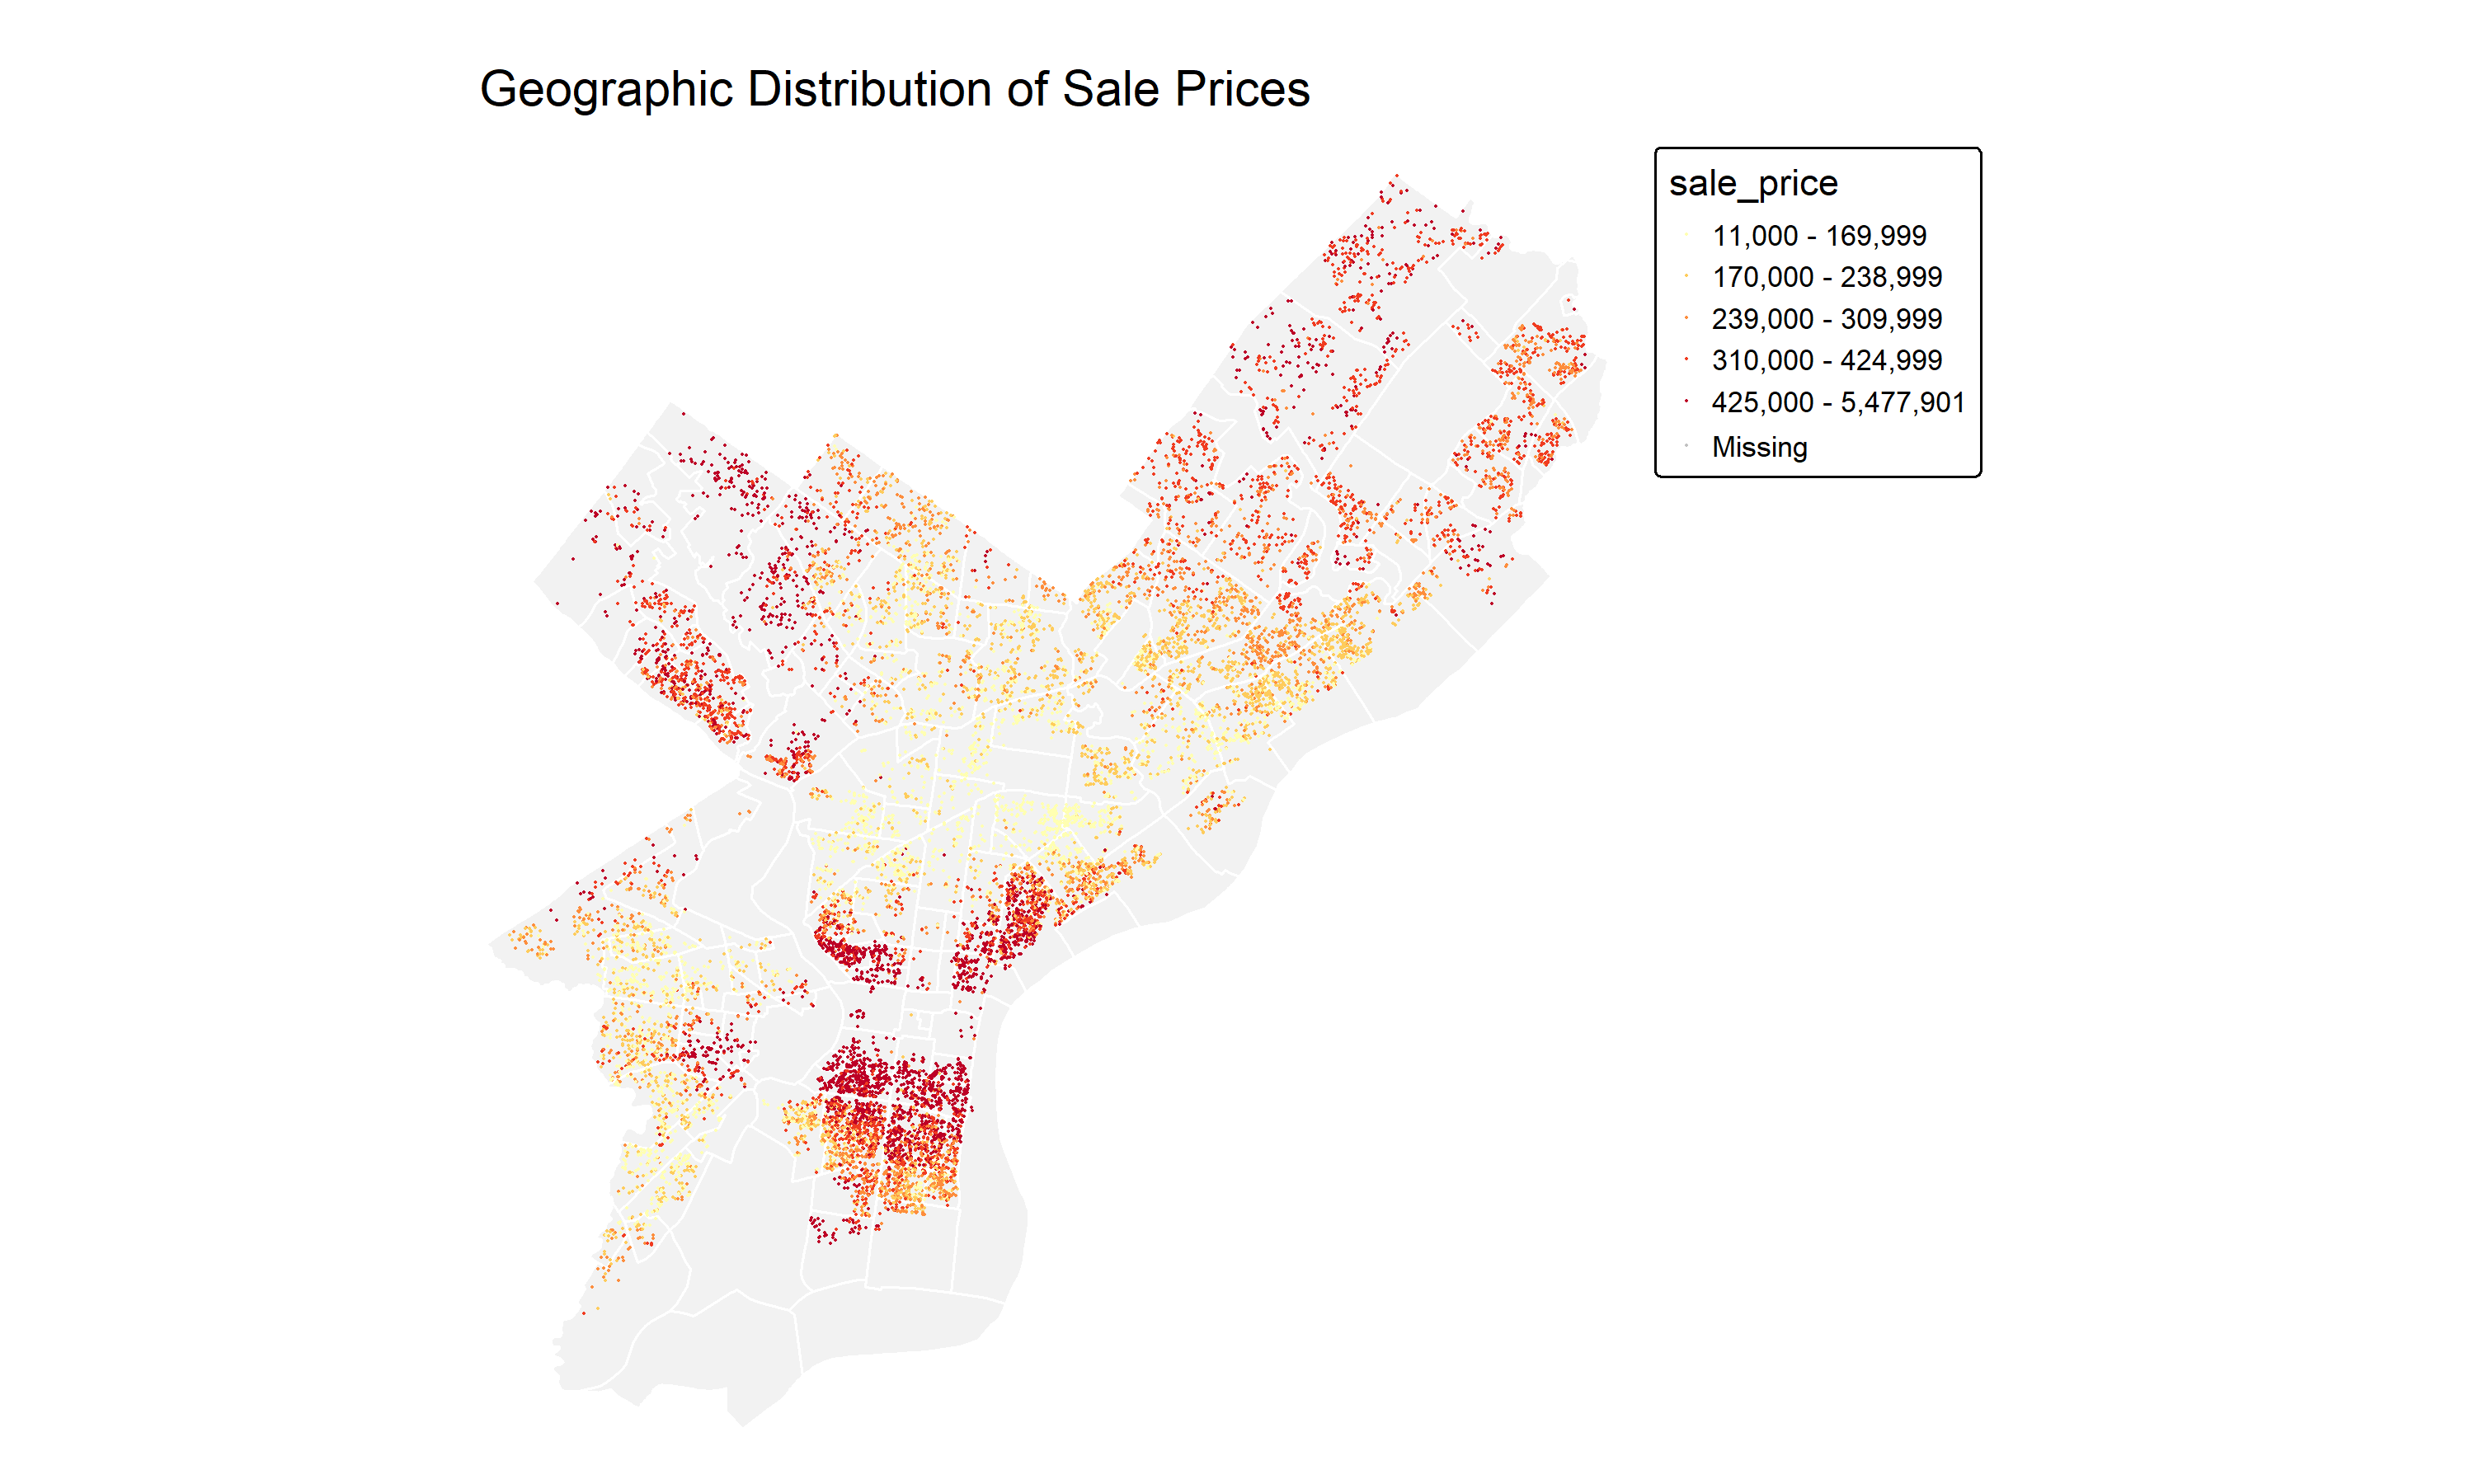

In [ ]:
#| label: geo-price-map
#| fig-width: 10
#| fig-height: 6
#| fig-dpi: 300
#| 
# Geographic distribution map - Sale Price

tmap_mode("plot")

**Geographic Distribution of Sales Prices - Map**

This map displays a high variation of sales prices distributed
throughout the city. The higher priced clustered areas are the Center
City, University City, the riverfront, and affluent pockets of the
Northwest, potentially because these areas provide easy access to
transit, employment centers, and cultural amenities. The northern area
stretching above Broad Street into parts of West and North Philadelphia
displays lower-priced homes, potentially reflecting long-term
disinvestment, high vacancy rates, and aging non-renovated housing
stock. The spatial clustering suggests that sale price is
place-dependent in Philadelphia, mostly due to neighborhood qualities,
and fixed effects.

`geom_smooth()` using formula = 'y ~ x'

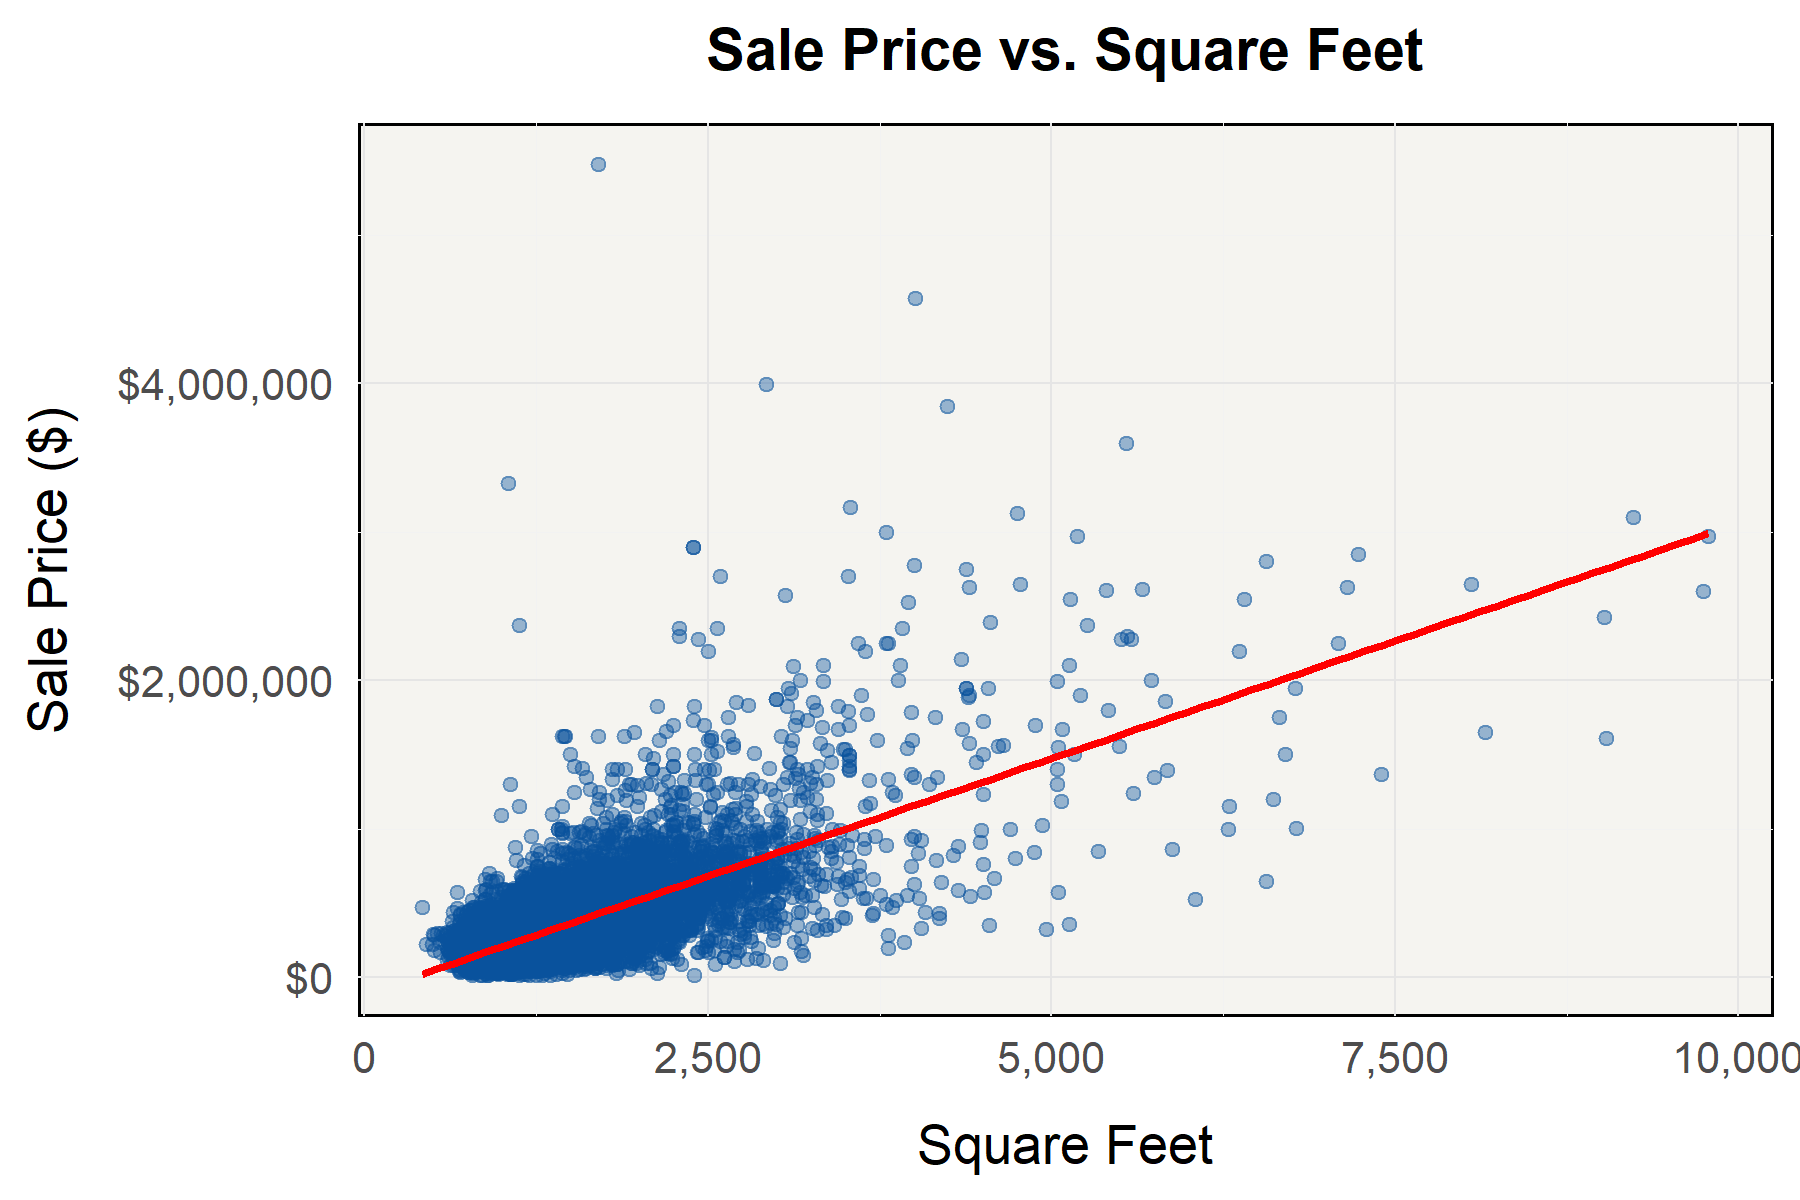

In [ ]:
#| label: price-v-sqft
#| fig-width: 6
#| fig-height: 4
#| fig-dpi: 300

# Sale Price vs structural features scatter plot

# Sale Price vs. Square feet 
price_v_sqft_plot <- ggplot(final_data, aes(x = square_feet, y = sale_price)) +
  geom_point(alpha = 0.4, color = "#08519C", size = 1.3) +
  geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 1) +
  labs(title = "Sale Price vs. Square Feet",
       x = "Square Feet",
       y = "Sale Price ($)") +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal(base_size = 13) +
  theme(
    panel.background = element_rect(fill = "#f5f4f0"),
    panel.grid.major = element_line(color = "gray90", size = 0.3),
    panel.grid.minor = element_line(color = "gray95", size = 0.2),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
    )

price_v_sqft_plot

**Sale Price vs. Square Feet**

This scatter plot highlights the importance of home size as a structural
indicator of value, even though the relationship may not be linear.
There is a dense concentration of homes clustered below 3,000 sq ft. and
under \$500,000 consistent with the sales price distribution. Here we
are seeing the same strong skew to the right, displaying a relationship
between the two variables. The upward trend is fairly obvious, larger
homes = an increase in price, however the spread gets wider as square
footage increases, indicating that while square footage is positively
associated with price, the weaker relationship among larger properties
suggests that additional living space contributes less to value once the
home reaches a certain size category.

`geom_smooth()` using formula = 'y ~ x'

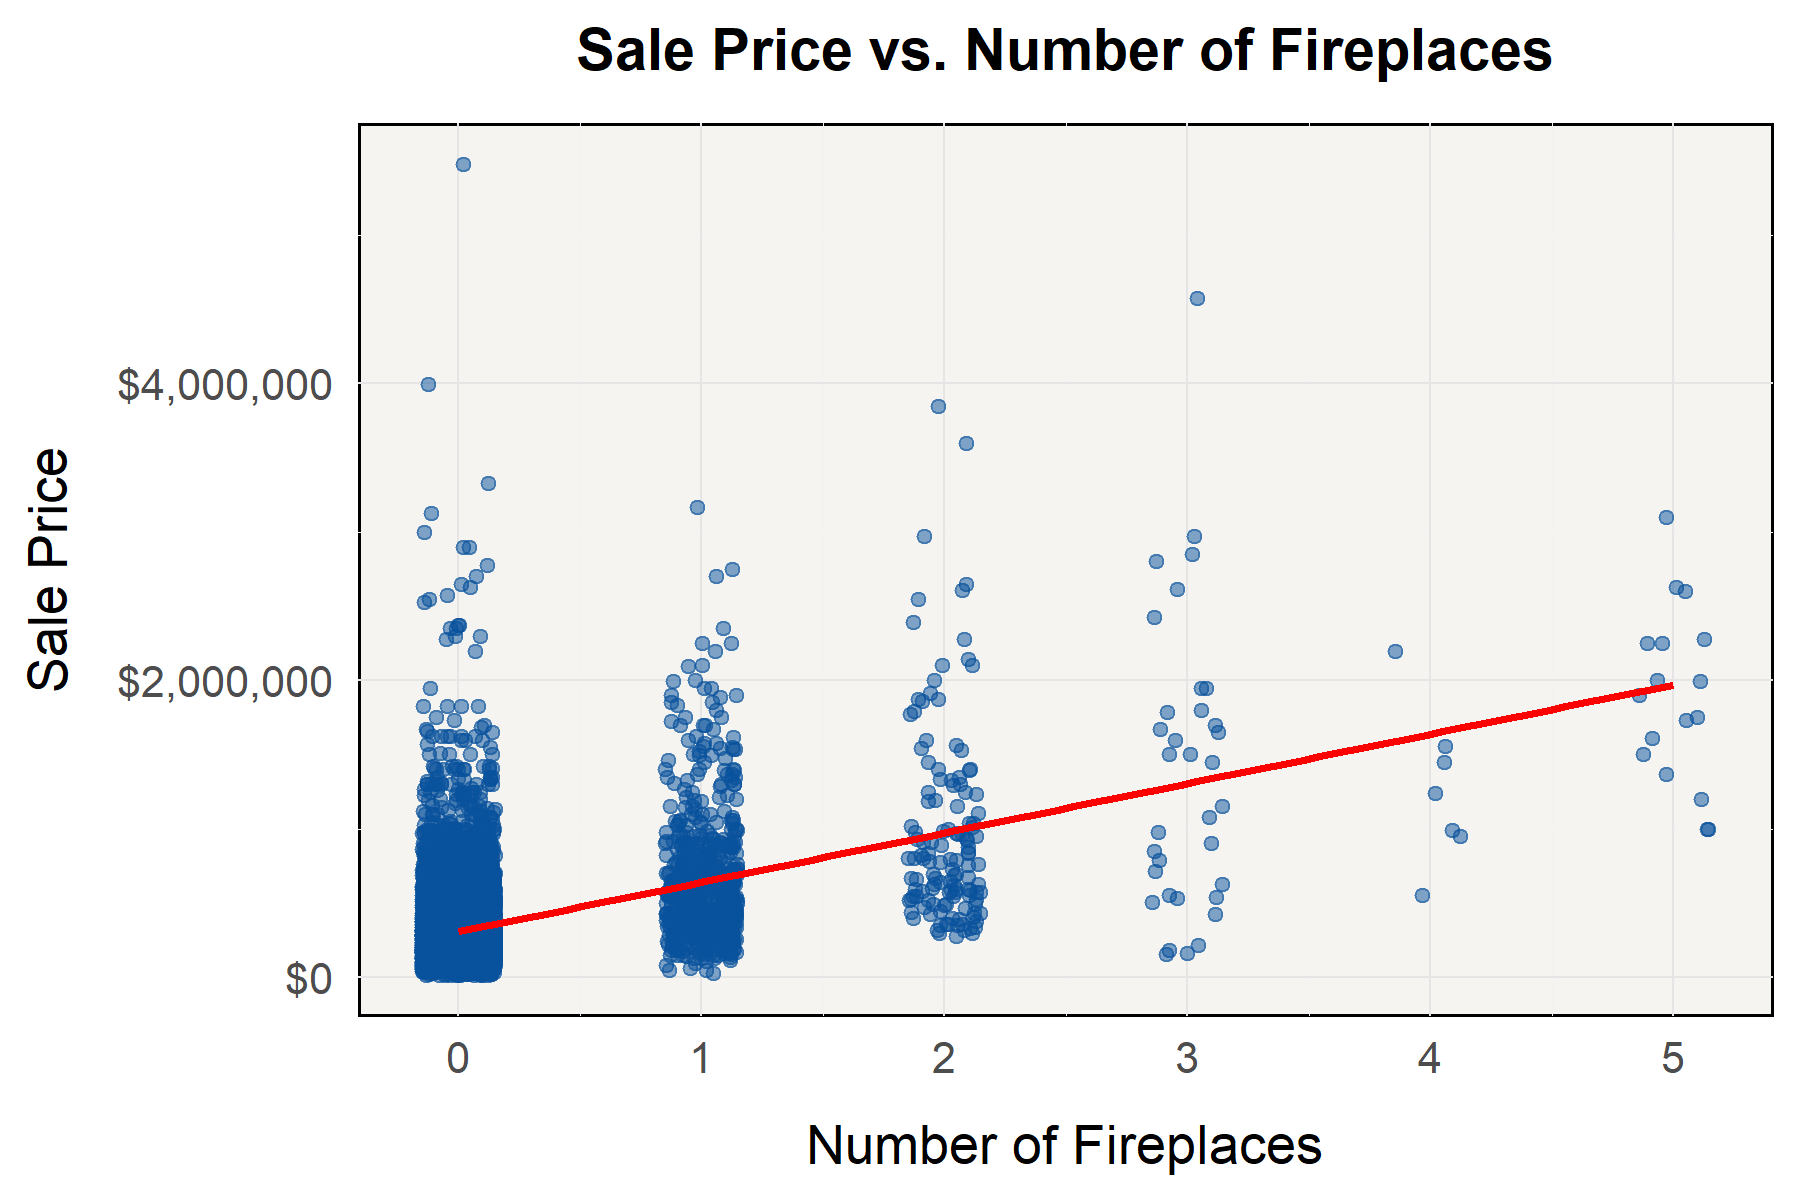

In [ ]:
#| label: price-v-fire
#| fig-width: 6
#| fig-height: 4
#| fig-dpi: 300

# Sale Price vs. Number of Fireplaces 

price_v_fire_plot <- ggplot(final_data, aes(x = fireplace_num, y = sale_price)) +
  geom_jitter(alpha = 0.5, color = "#08519C", size = 1.3, width = 0.15, height = 0) +
  geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 1) +
  labs(title = "Sale Price vs. Number of Fireplaces",
       x = "Number of Fireplaces",
       y = "Sale Price") +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal(base_size = 13) +
  theme(
    panel.background = element_rect(fill = "#f5f4f0"),
    panel.grid.major = element_line(color = "gray90", size = 0.3),
    panel.grid.minor = element_line(color = "gray95", size = 0.2),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
    )

price_v_fire_plot

**Sale Price vs. Number of Fireplaces**

This chart displays the positive relationship between the value of a
home in relation to the quality and character of aesthetic features.
Nearly all homes with no fireplaces remain in the lower-mid price range,
and once a home has two or more fire places the sale price increases to
a much higher range. Homes in Philadelphia with several fireplaces are
usually bigger, older, homes with higher-end finishes, meaning that
fireplace count can serve as a secondary and indirect indicator of
several other indicators that influence home value, and this is the
reason for the high level of noise on the chart.

`geom_smooth()` using formula = 'y ~ x'

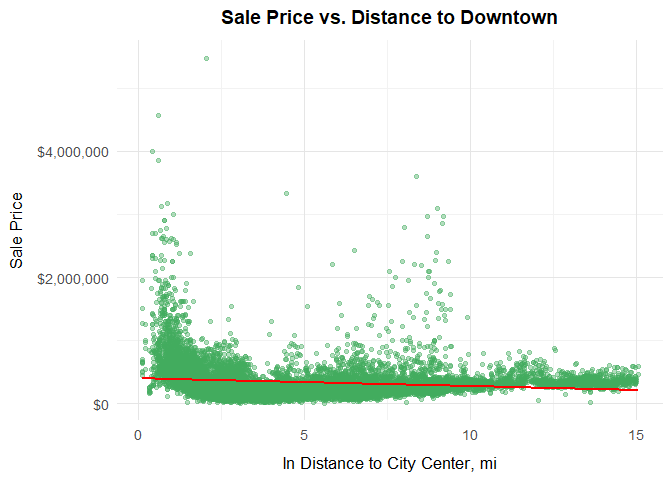

In [ ]:
# Sale Price vs. Spatial Features

# Sale Price vs Distance to city center
price_v_spatial_plot <- ggplot(final_data, aes(x = city_dist_mi, y = sale_price)) +
  geom_point(alpha = 0.4, color = "#41AB5D", size = 1.3) +
  geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 1) +
  labs(title = "Sale Price vs. Distance to Downtown",
       x = "ln Distance to City Center, mi",
       y = "Sale Price") +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.major = element_line(color = "gray90", size = 0.3),
    panel.grid.minor = element_line(color = "gray95", size = 0.2),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
    )

price_v_spatial_plot

**Sale Price vs. Distance to City Center**

The plots shows a weak negative relationship between price and distance
to the city center. High valued homes fall both close to downtown and
well outside of it, highlighting the structure of Philadelphia’s housing
market as it relates to location. It’s not a city where closer is always
better, instead certain neighborhoods like chestnut hill maintain their
high premiums due to neighborhood reputation, and school quality. This
pattern suggests that there are many fixed affects at play here, and it
is important to note that similar patterns were displayed among many
spatial variables.

`geom_smooth()` using formula = 'y ~ x'

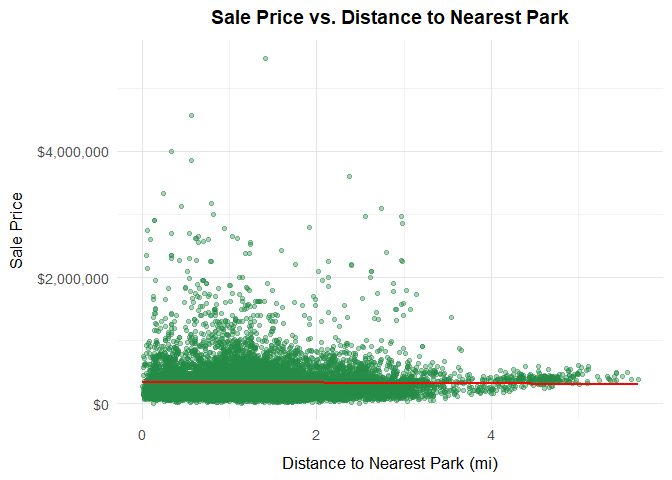

In [ ]:
# Sale Price vs. Distance to Parks - Park Accessibility

price_v_park_plot <- ggplot(final_data, aes(x = parks_mile, y = sale_price)) +
  geom_point(alpha = 0.4, color = "#238B45", size = 1.3) +
  geom_smooth(method = "lm", se = FALSE, color = "red", linewidth = 1) +
  labs(title = "Sale Price vs. Distance to Nearest Park",
       x = "Distance to Nearest Park (mi)",
       y = "Sale Price") +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.major = element_line(color = "gray90", size = 0.3),
    panel.grid.minor = element_line(color = "gray95", size = 0.2),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
    )

price_v_park_plot

**Sale Price vs. Distance to Parks - Park Accessibility**

The plot suggests that distance to parks has very little trend with sale
price. Many high-priced properties sit both very close and very far away
from parks, suggesting that park accessibility alone may not hold much
value. This could be correlated with the fact that some parks are major
attractions; i.e Fairmount Park, while others have limited impact on
neighborhood desirability, especially in areas of low investment.
Because of the difference in park quality across the city, the distance
metric may not represents the true relationship, and more neighborhood
or amenity variables may be required to capture environmental quality
more accurately.

In [ ]:
#| label: inv-v-price-plot
#| fig-width: 15
#| fig-height: 10
#| fig-dpi: 600

# Median income vs Sale Price per neighborhood

inc_v_price_plot <- ggplot(final_data, aes(x = medhhinc, y = sale_price, color = neighborhood_fe)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "Relationship Between Median Income and Sale Price by Neighborhood",
       x = "Median Household Income ($)",
       y = "Sale Price") +
  scale_x_continuous(labels = scales::dollar) +
  scale_y_continuous(labels = scales::dollar) +
  scale_color_viridis_d(option = "turbo") +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.major = element_line(color = "gray90", size = 0.3),
    panel.grid.minor = element_line(color = "gray95", size = 0.2),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 10)),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    legend.position = "bottom",
    legend.text = element_text(size = 7),
    legend.key.size = unit(0.4, "cm"),
    legend.box = "horizontal"
    ) +
  guides(color = guide_legend(ncol = 8, byrow = TRUE))

inc_v_price_plot

`geom_smooth()` using formula = 'y ~ x'

**Median Income vs Sale Price per neighborhood**

This plot further advances the claim that even with a lot of scatter in
the points, there is a noticeable upward trend of homes in higher-income
neighborhoods selling for higher prices. Many of the neighborhoods
cluster in specific ranges of the price scale, even when income levels
are similar, suggesting that the housing market in Philadelphia is
dependent not only on demographics or income, but place effects, where
reputation or fixed effects in a neighborhood increase or reduce prices.
An example of this is some neighborhoods with moderate household incomes
still show clusters of high-value transactions, while others with
similar incomes remain in the lower end of the market, again
highlighting other factors and fixed effects like transit access,
historical character, and school quality. The main takeaway is that
while higher-income neighborhood tend to have homes with higher sale
prices, neighborhood identity also plays a big role in sale price.

In [ ]:
# Spatial Relationship Between sale price and structural predictors

tmap_mode("plot")

ℹ tmap modes "plot" - "view"


── tmap v3 code detected ───────────────────────────────────────────────────────
[v3->v4] `tm_dots()`: instead of `style = "quantile"`, use fill.scale =
`tm_scale_intervals()`.
ℹ Migrate the argument(s) 'style', 'palette' (rename to 'values') to
  'tm_scale_intervals(<HERE>)'[tm_dots()] Argument `title` unknown.[v3->v4] `tm_layout()`: use `tm_title()` instead of `tm_layout(main.title = )`

In [ ]:
# Bathrooms Predictor

map_bath <-  tm_shape(philly_tracts[philly_tracts$COUNTYFP == 101, ]) +
  tm_polygons(col = "gray90", border.col = "gray45", lwd = 0.5) +
  tm_shape(final_data) +
  tm_dots(col = "bath_num",
          palette = "Blues",
          style = "quantile",
          size = 0.04,
          title = "Number of Bathrooms") +
  tm_layout(main.title = "Distribution of Bathrooms",
            main.title.position = "center",
            main.title.size = 1.2,
            legend.outside = TRUE,
            frame = FALSE)

[tm_dots()] Argument `title` unknown.
[v3->v4] `tm_layout()`: use `tm_title()` instead of `tm_layout(main.title = )`

In [ ]:
# Stories Predictor

map_story <-  tm_shape(philly_tracts[philly_tracts$COUNTYFP == 101, ]) +
  tm_polygons(col = "gray90", border.col = "gray45", lwd = 0.5) +
  tm_shape(final_data) +
  tm_dots(col = "story_num",
          palette = "Greens",
          style = "quantile",
          size = 0.04,
          title = "Number of Stories") +
  tm_layout(main.title = "Distribution of Stories",
            main.title.position = "center",
            main.title.size = 1.2,
            legend.outside = TRUE,
            frame = FALSE)

[tm_dots()] Argument `title` unknown.
[v3->v4] `tm_layout()`: use `tm_title()` instead of `tm_layout(main.title = )`

[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "YlOrRd" is named
"brewer.yl_or_rd"
Multiple palettes called "yl_or_rd" found: "brewer.yl_or_rd", "matplotlib.yl_or_rd". The first one, "brewer.yl_or_rd", is returned.

[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "Blues" is named
"brewer.blues"
Multiple palettes called "blues" found: "brewer.blues", "matplotlib.blues". The first one, "brewer.blues", is returned.

[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "Greens" is named
"brewer.greens"
Multiple palettes called "greens" found: "brewer.greens", "matplotlib.greens". The first one, "brewer.greens", is returned.

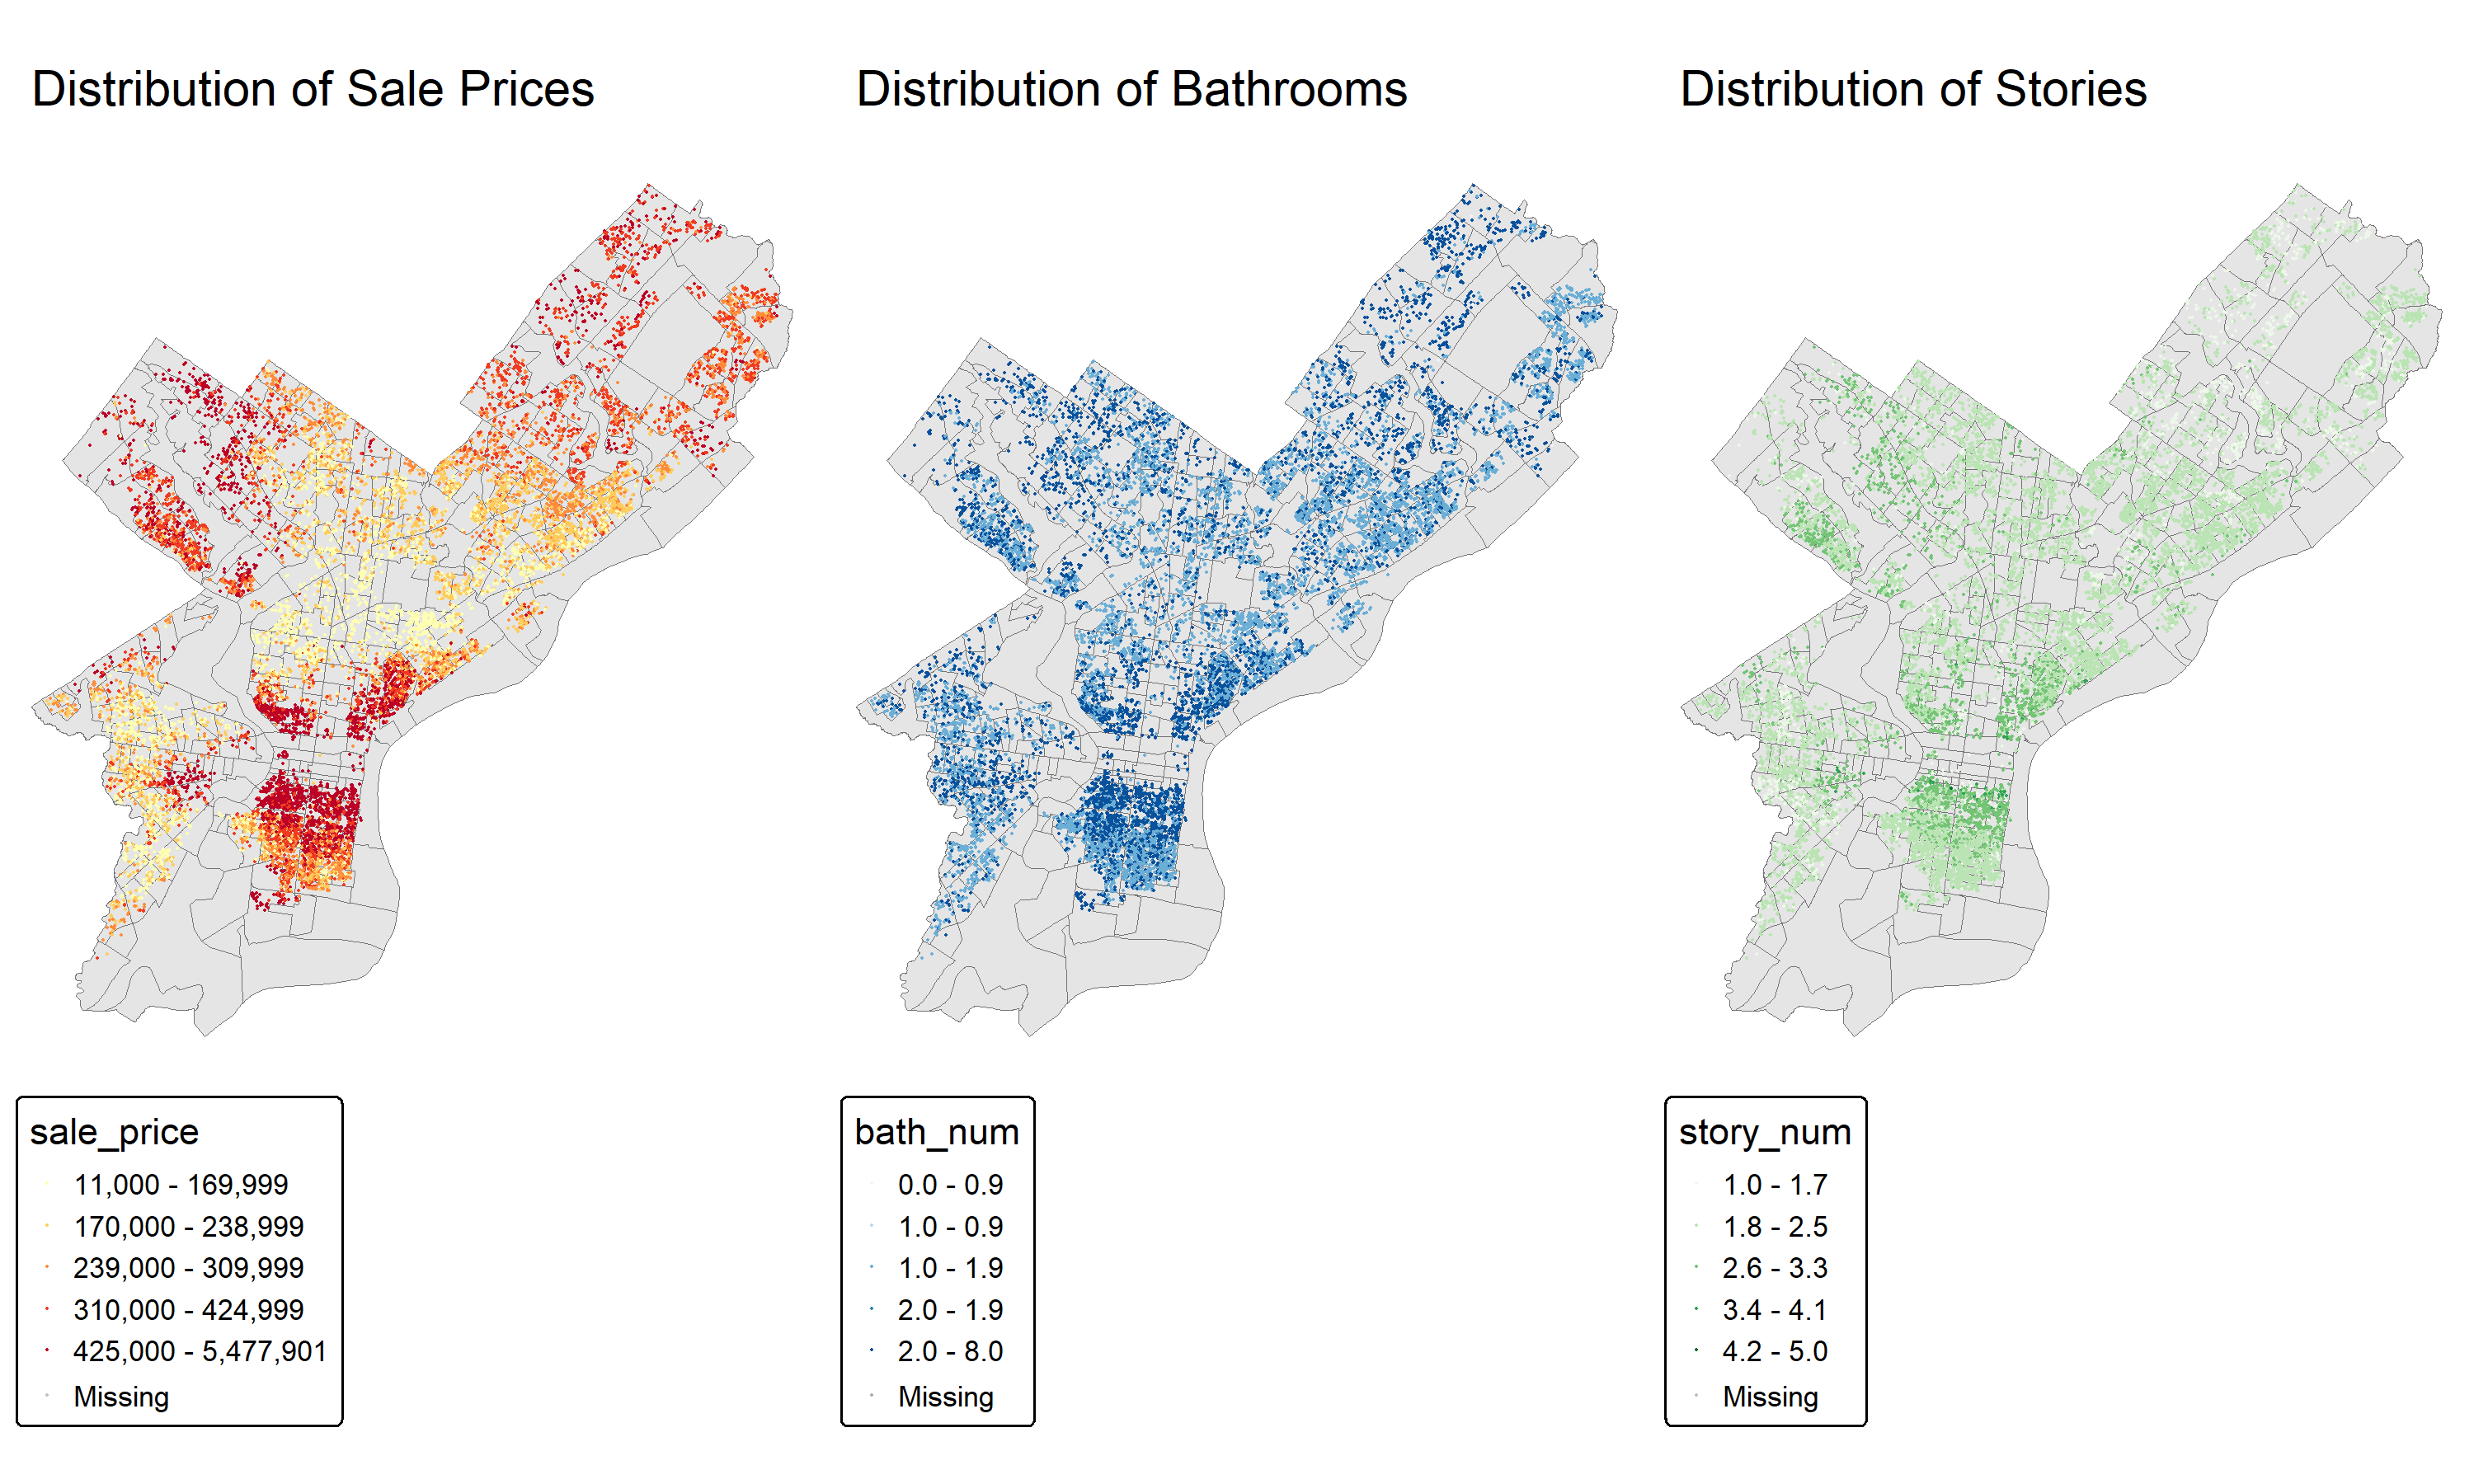

In [ ]:
#| label: geo-facet-map
#| fig-width: 10
#| fig-height: 6
#| fig-dpi: 300

# Display them side by side

tmap_arrange(map_value, map_bath, map_story, ncol = 3)

**Spatial Relationship Between sale price and structural predictors
(bathrooms and stories) - Map**

This figure shows how housing characteristics are clustered across
Philadelphia. Here we can see the sale price distribution directly
against certain structural features. Bathrooms and number of stories
follow similar geographic patterns, as sale price, areas with higher
sales prices tend to have bigger homes with more bathrooms and more
stories. In contrast, neighborhoods where homes have less structural
amenities also have subsequently lower sale prices. This group of maps
makes a strong visual argument that structural features and neighborhood
context evolve together, supporting the modeling strategy of
incorporating more structural than spatial predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

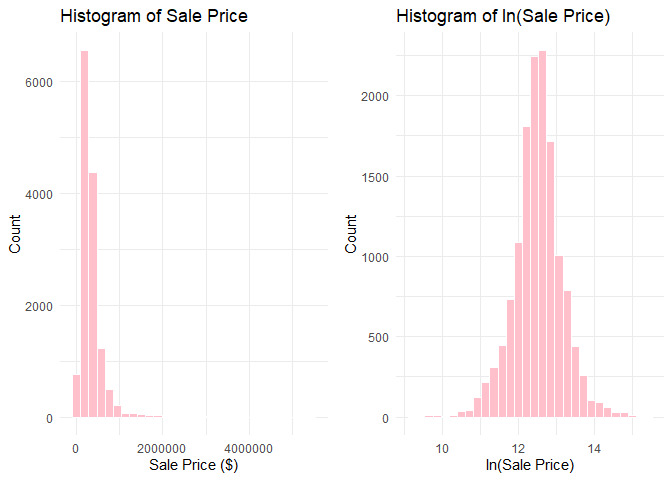

In [ ]:
# Sale price histogram.
price_hist <- ggplot(residential_points, aes(x = sale_price)) +
  geom_histogram(fill = "pink", color = "white") +
  labs(title = "Histogram of Sale Price", x = "Sale Price ($)", y = "Count") +
  theme_minimal()

# Log sale price histogram.
ln_price_hist <- ggplot(residential_points, aes(x = ln_sale_price)) +
  geom_histogram(fill = "pink", color = "white") +
  labs(title = "Histogram of ln(Sale Price)", x = "ln(Sale Price)", y = "Count") +
  theme_minimal()

grid.arrange(price_hist, ln_price_hist, ncol = 2)

The raw distribution of sale prices is right-skewed with a median of
250,000 USD and a mean of 343,867 USD. There is a substantial gap in
price between the third quartile (375,000 USD) and the maximum price
(15,428,633 USD). While 75% of houses sold for 375,000 USD or less, the
upper 25% exhibits considerable variability, with prices ranging up to
15.4 million USD, affecting the tail distribution. This suggests that a
small number of luxury properties are affecting the distribution of the
sales price data To address this skewness and improve model performance,
we performed a log transformation, making our data closer to normal by
compressing the scale of higher values, emphasizing a standardized
change in percentage over dollar amount.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

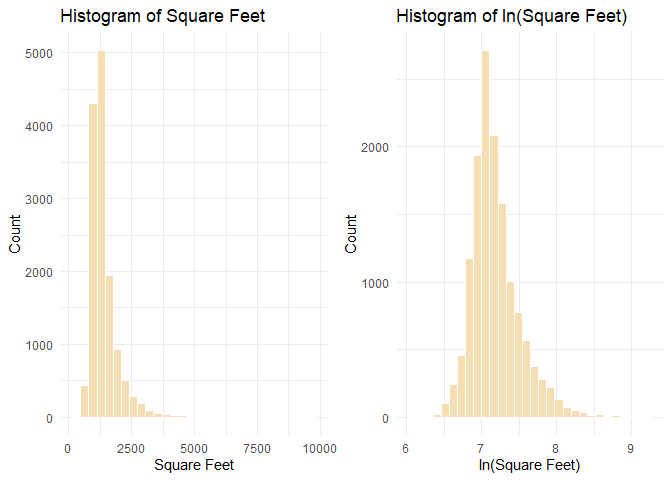

In [ ]:
# Livable space histogram.
livable_area_hist <- ggplot(residential_points, aes(x = square_feet)) +
  geom_histogram(fill = "wheat", color = "white") +
  labs(title = "Histogram of Square Feet", x = "Square Feet", y = "Count") +
  theme_minimal()

# Log livable space histogram.
ln_square_feet_hist <- ggplot(residential_points, aes(x = ln_square_feet)) +
  geom_histogram(fill = "wheat", color = "white") +
  labs(title = "Histogram of ln(Square Feet)", x = "ln(Square Feet)", y = "Count") +
  theme_minimal()

grid.arrange(livable_area_hist, ln_square_feet_hist, ncol = 2)

The distribution of livable area is right-skewed, with a median of 1,216
sq ft and a mean of 1,372 sq ft. While 75% of homes are under 1,509 sq
ft, a small number of larger properties extend the upper tail of the
distribution. Notably, homes above 3,000 sq ft become increasingly
sparse, suggesting a separation between standard and luxury housing
markets. We applied a log transformation to this variable to create a
more symmetric distribution by compressing the scale of larger homes,
which improves linearity in our model and allows coefficients to
represent proportional rather than absolute changes in square footage.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

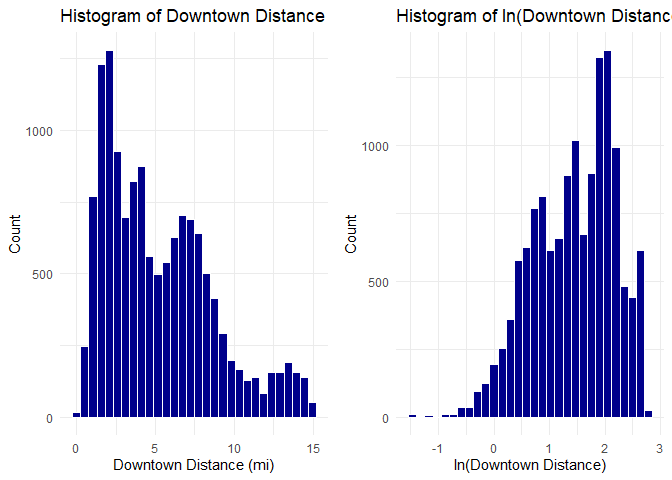

In [ ]:
# Distance to downtown histogram.
downtown_dist_hist <- ggplot(residential_points, aes(x = city_dist_mi)) +
  geom_histogram(fill = "darkblue", color = "white") +
  labs(title = "Histogram of Downtown Distance", x = "Downtown Distance (mi)", y = "Count") +
  theme_minimal()

# Log distance to downtown histogram.
ln_downtown_dist_hist <- ggplot(residential_points, aes(x = ln_city_dist)) +
  geom_histogram(fill = "darkblue", color = "white") +
  labs(title = "Histogram of ln(Downtown Distance)", x = "ln(Downtown Distance)", y = "Count") +
  theme_minimal()

grid.arrange(downtown_dist_hist, ln_downtown_dist_hist, ncol = 2)

The distribution of distance to Center City (City Hall) is right-skewed,
with fewer observations of houses occurring as the distance from Center
City/City Hall increases. The effect of distance on housing prices is
non-linear: being 1 mile from Center City has a larger impact on price
than being 6 vs. 11 miles out. To account for this, we applied a log
transformation, which compresses the upper tail, creates a more
symmetric distribution, and reduces the influence of extreme distances.
This transformation improves linearity in our regression model and
allows coefficients to be interpreted as proportional changes in price
per proportional change in distance.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

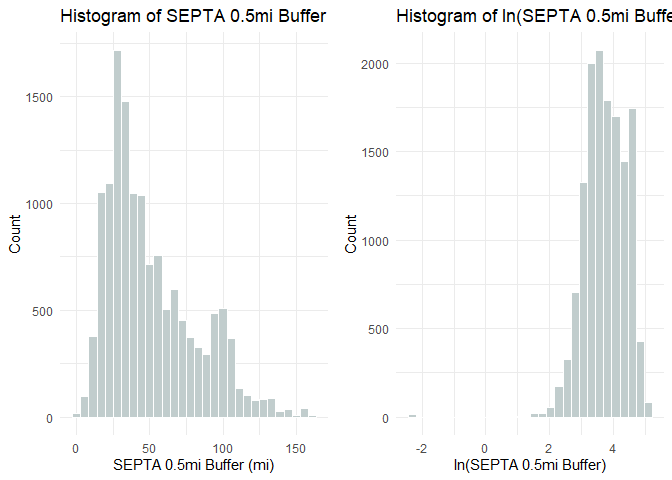

In [ ]:
# SEPTA buffer histogram.
septa_buffer_hist <- ggplot(residential_points, aes(x = septa_half_mi)) +
  geom_histogram(fill = "azure3", color = "white") +
  labs(title = "Histogram of SEPTA 0.5mi Buffer", x = "SEPTA 0.5mi Buffer (mi)", y = "Count") +
  theme_minimal()

# Log SEPTA buffer histogram.
ln_septa_buffer_hist <- ggplot(residential_points, aes(x = ln_septa_half_mi)) +
  geom_histogram(fill = "azure3", color = "white") +
  labs(title = "Histogram of ln(SEPTA 0.5mi Buffer)", x = "ln(SEPTA 0.5mi Buffer)", y = "Count") +
  theme_minimal()

grid.arrange(septa_buffer_hist, ln_septa_buffer_hist, ncol = 2)

The distribution of SEPTA access within a 0.5-mile buffer of each
property is right-skewed, with a median of 44 and a mean of 52.5. While
most properties have between 29 and 69 nearby SEPTA access points, there
is substantial variation ranging from zero (likely remote suburban
properties) to over 160 in the most transit-dense neighborhoods. The log
transformation compresses this wide range and produces a more symmetric
distribution, which is appropriate given that transit accessibility
exhibits diminishing returns—the marginal benefit of additional access
decreases as the total number increases.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

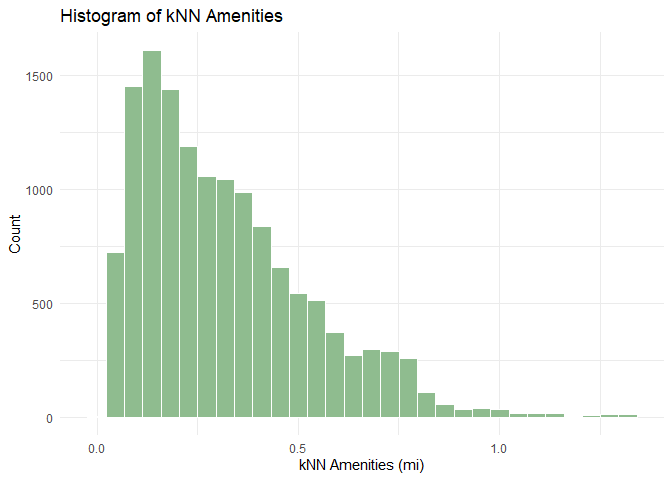

In [ ]:
# kNN amenities histogram.
knn_amenities_hist <- ggplot(residential_points, aes(x = knn_amenity_mi)) +
  geom_histogram(fill = "darkseagreen", color = "white") +
  labs(title = "Histogram of kNN Amenities", x = "kNN Amenities (mi)", y = "Count") +
  theme_minimal()

grid.arrange(knn_amenities_hist)

For the kNN Amenities variable, the mean distance to the nearest amenity
per household is 0.31 miles, and the median is 0.27 miles. Seventy-five
percent of households are within 0.42 miles of any of the 23 amenities
described in the data cleaning section. These statistics showcase
Philadelphia’s reputation as a highly walkable city. Observations beyond
1 mile typically reflect suburban or rural settings. We did not
transform this variable, instead using the raw distances to preserve the
direct relationship between amenity proximity and property values.The
kNN approach inherently reflects local amenity density, with shorter
distances in denser areas and longer distances where households are more
dispersed.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

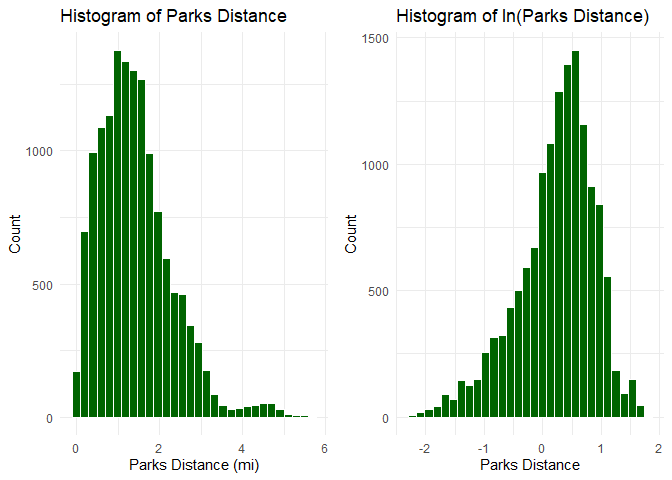

In [ ]:
# Distance to park histogram..
parks_dist <- ggplot(residential_points, aes(x = parks_mile)) +
  geom_histogram(fill = "darkgreen", color = "white") +
  labs(title = "Histogram of Parks Distance", x = "Parks Distance (mi)", y = "Count") +
  theme_minimal()

# Log distance to park histogram.
ln_parks_dist <- ggplot(residential_points, aes(x = ln_park_dist)) +
  geom_histogram(fill = "darkgreen", color = "white") +
  labs(title = "Histogram of ln(Parks Distance)", x = "Parks Distance", y = "Count") +
  theme_minimal()

grid.arrange(parks_dist, ln_parks_dist, ncol = 2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

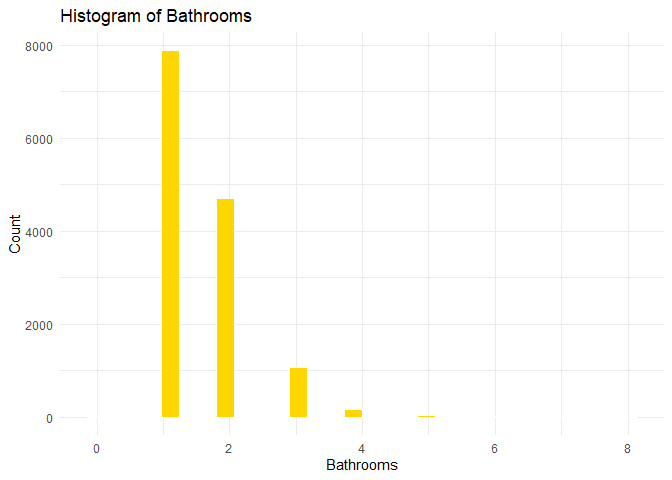

In [ ]:
# Number of bathrooms histogram.
ggplot(residential_points, aes(x = bath_num)) +
  geom_histogram(fill = "gold", color = "white") +
  labs(title = "Histogram of Bathrooms", x = "Bathrooms", y = "Count") +
  theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

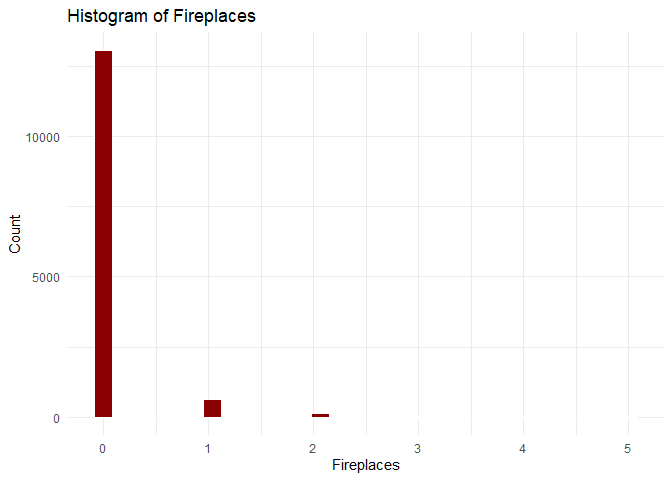

In [ ]:
# Number of fireplaces histogram.
ggplot(residential_points, aes(x = fireplace_num)) +
  geom_histogram(fill = "darkred", color = "white") +
  labs(title = "Histogram of Fireplaces", x = "Fireplaces", y = "Count") +
  theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

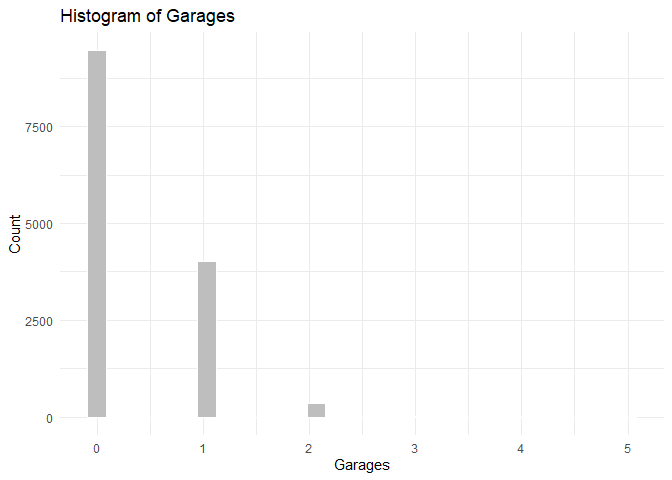

In [ ]:
# Number of garages histogram.
ggplot(residential_points, aes(x = garage_num)) +
  geom_histogram(fill = "gray", color = "white") +
  labs(title = "Histogram of Garages", x = "Garages", y = "Count") +
  theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

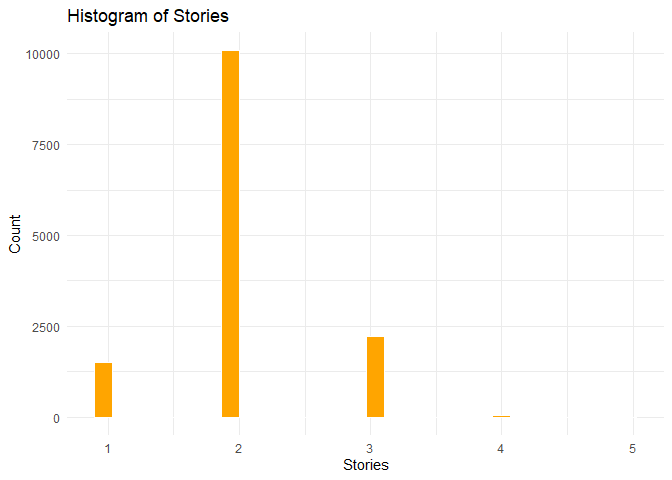

In [ ]:
# Number of stories histogram.
ggplot(residential_points, aes(x = story_num)) +
  geom_histogram(fill = "orange", color = "white") +
  labs(title = "Histogram of Stories", x = "Stories", y = "Count") +
  theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

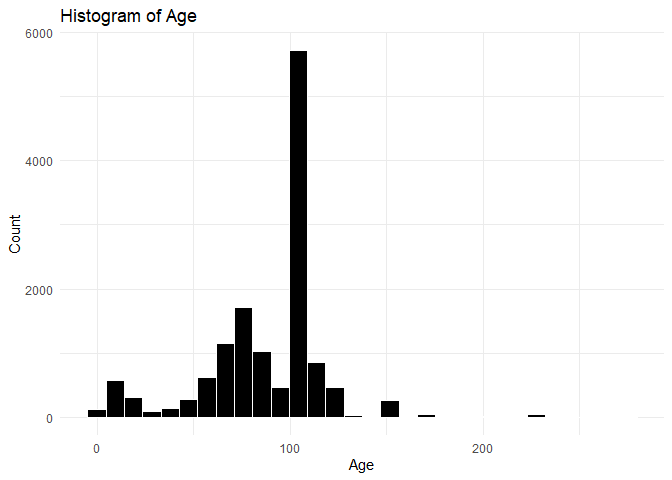

In [ ]:
# Age histogram.
ggplot(residential_points, aes(x = age)) +
  geom_histogram(fill = "black", color = "white") +
  labs(title = "Histogram of Age", x = "Age", y = "Count") +
  theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`stat_bin()`).

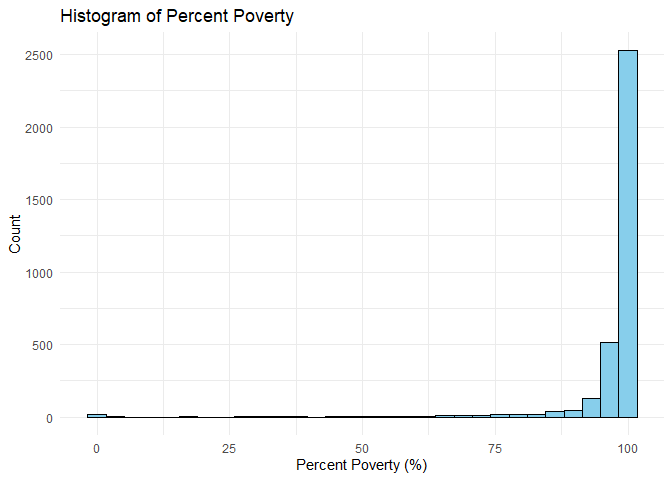

In [ ]:
# Histogram for pct_poverty
ggplot(philly_acs_summary, aes(x = pct_poverty)) +
  geom_histogram(fill = "skyblue", color = "black") +
  labs(title = "Histogram of Percent Poverty", x = "Percent Poverty (%)", y = "Count") +
  theme_minimal()

(`stat_bin()`).

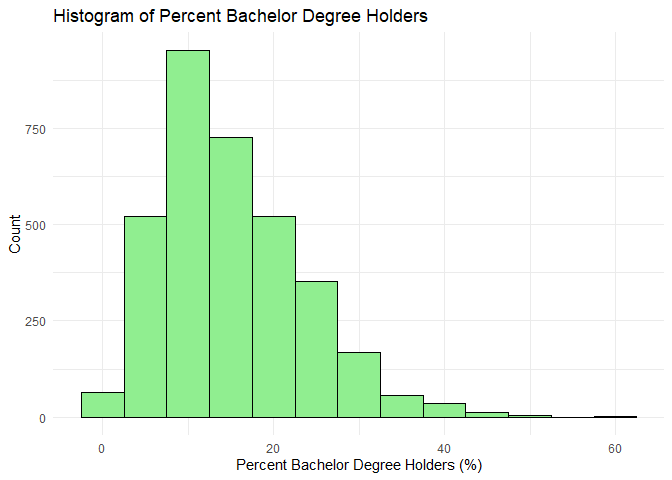

In [ ]:
# Histogram for pct_bach
ggplot(philly_acs_summary, aes(x = pct_bach)) +
  geom_histogram(binwidth = 5, fill = "lightgreen", color = "black") +
  labs(title = "Histogram of Percent Bachelor Degree Holders", x = "Percent Bachelor Degree Holders (%)", y = "Count") +
  theme_minimal()

(`stat_bin()`).

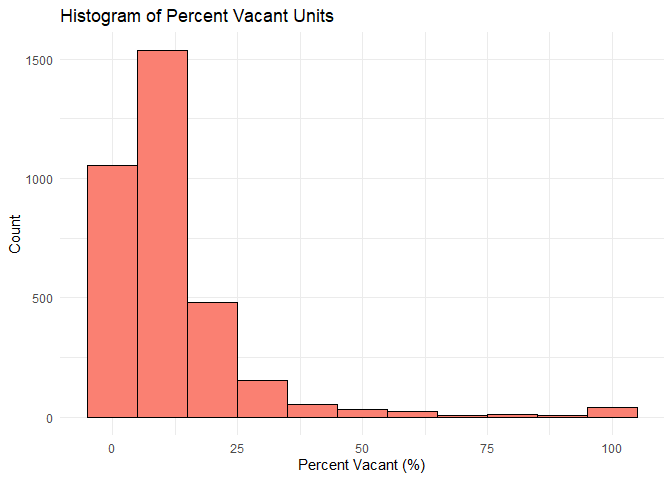

In [ ]:
# Histogram for pct_vacant
ggplot(philly_acs_summary, aes(x = pct_vacant)) +
  geom_histogram(binwidth = 10, fill = "salmon", color = "black") +
  labs(title = "Histogram of Percent Vacant Units", x = "Percent Vacant (%)", y = "Count") +
  theme_minimal()

(`stat_bin()`).

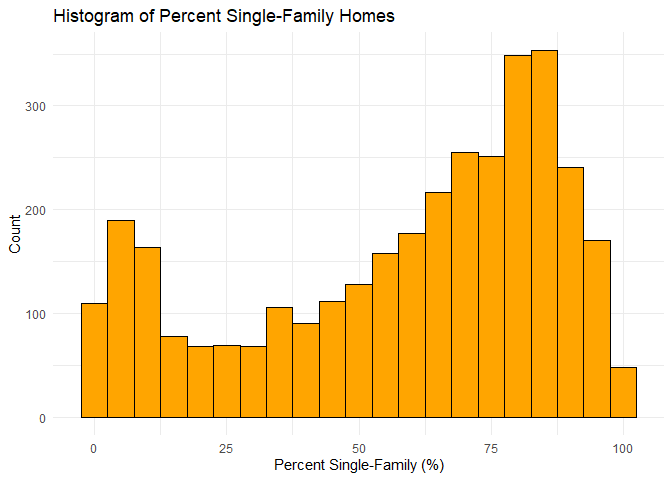

In [ ]:
# Histogram for pct_single_family
ggplot(philly_acs_summary, aes(x = pct_single_family)) +
  geom_histogram(binwidth = 5, fill = "orange", color = "black") +
  labs(title = "Histogram of Percent Single-Family Homes ", x = "Percent Single-Family (%)", y = "Count") +
  theme_minimal()

(`stat_bin()`).

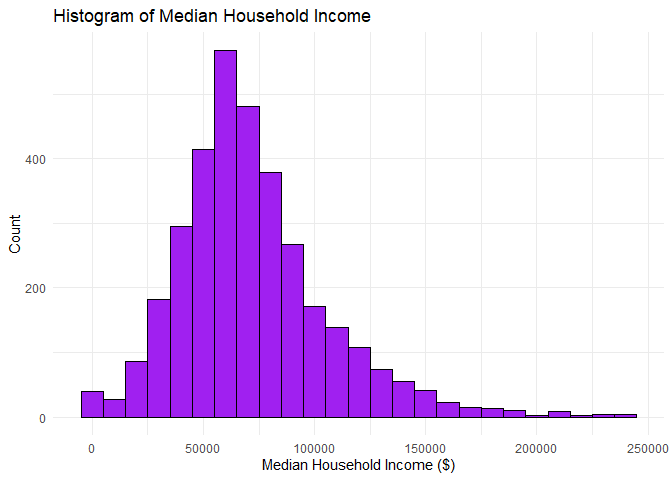

In [ ]:
# Histogram for medhhinc
ggplot(philly_acs_summary, aes(x = medhhinc)) +
  geom_histogram(binwidth = 10000, fill = "purple", color = "black") +
  labs(title = "Histogram of Median Household Income", x = "Median Household Income ($)", y = "Count") +
  theme_minimal()

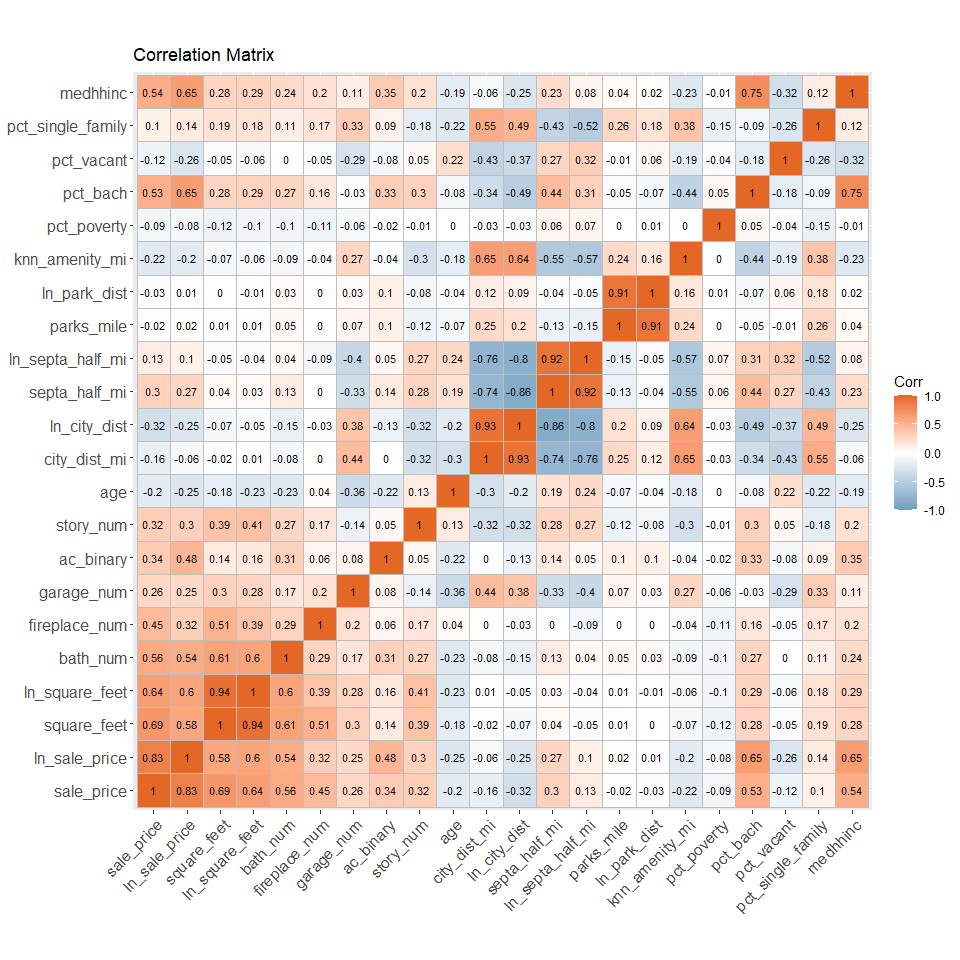

In [ ]:
#| fig.width: 10
#| fig.height: 10

# Residential property correlation.
corr_matrix_df <- final_data %>%
  select(1:22) %>%
  st_drop_geometry()

corr_matrix <- round(cor(na.omit(corr_matrix_df)), 2)

corr_matrix_plot <- ggcorrplot(corr_matrix,
                               title = "Correlation Matrix",
                               hc.order = FALSE,
                               method = "square",
                               lab = TRUE,
                               lab_size = 3,
                               colors = c("#6D9EC1", "white", "#E46726"),
                               ggtheme = ggplot2::theme_gray,
                               insig = "blank"
                               )

corr_matrix_plot

Probably should use ln(sale price) as the response because it doesn’t
have a linear relationship with a lot of the variables and has
diminishing returns with many of them.

Strongest predictors to ln(sale price) (positive values) descending are:

-   ln(livable area) at 0.51 \> total livable area at 0.50

-   bathrooms at 0.48

-   AC at 0.47

-   fireplaces at 0.29

-   stories at 0.27

-   amenities index at 0.26

-   garage spaces at 0.22

-   half mile septa at 0.22 \> ln(half mile septa) at 0.07

-   parks buffer at 0.06 same as ln(parks buffer) at 0.06

-   ln(distance downtown) at 0.03

# Model Building

## Model Building Progression

**Check for multicollinearity:**

In [ ]:
# VIF check for multicollinearity.
vif_check <- lm(ln_sale_price ~ ln_square_feet + bath_num + ac_binary + fireplace_num + story_num  + garage_num + ln_septa_half_mi + ln_park_dist + ln_city_dist + basement_type + fuel_type, data = residential_points)

vif(vif_check)

                     GVIF Df GVIF^(1/(2*Df))
ln_square_feet   2.135764  1        1.461425
bath_num         1.898126  1        1.377725
ac_binary        1.326611  1        1.151786
fireplace_num    1.254647  1        1.120110
story_num        1.480500  1        1.216758
garage_num       2.278251  1        1.509387
ln_septa_half_mi 3.022487  1        1.738530
ln_park_dist     1.042356  1        1.020958
ln_city_dist     3.366197  1        1.834720
basement_type    3.098173 10        1.058170
fuel_type        1.050158  3        1.008190

In [ ]:
# Build Model step by step
# First Model (structural features only)

first_model <- lm(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2), # Age polynomial.
                    data = final_data)

summary(first_model)


Call:
lm(formula = sale_price ~ ln_square_feet + bath_num + ac_binary + 
    fireplace_num + story_num + garage_num + basement_type + 
    fuel_type + age + I(age^2), data = final_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-948550  -77612  -12427   56061 4967680 

Coefficients:
                                          Estimate    Std. Error t value
(Intercept)                          -1573115.2430    47184.2963 -33.340
ln_square_feet                         265324.4547     6777.4520  39.148
bath_num                                50976.0380     2850.5451  17.883
ac_binary                               93358.6805     3519.3817  26.527
fireplace_num                          139754.2587     4574.3312  30.552
story_num                               36185.3161     3367.8324  10.744
garage_num                              73507.4314     4149.3241  17.716
basement_typeFull Finished             -53619.3219    10227.7625  -5.243
basement_typeFull Semi-Finished        -64747.7

In [ ]:
# Build Model step by step
# Second Model (structural features + census features)

second_model <- lm(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2) + # Age polynomial.
                    medhhinc + pct_vacant + pct_single_family, # Census feature.
                    data = final_data)

summary(second_model)


Call:
lm(formula = sale_price ~ ln_square_feet + bath_num + ac_binary + 
    fireplace_num + story_num + garage_num + basement_type + 
    fuel_type + age + I(age^2) + medhhinc + pct_vacant + pct_single_family, 
    data = final_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-988077  -66190   -4479   51392 5089350 

Coefficients:
                                           Estimate     Std. Error t value
(Intercept)                          -1631653.69177    43478.62618 -37.528
ln_square_feet                         249024.29196     6287.93299  39.604
bath_num                                57294.02210     2625.66512  21.821
ac_binary                               51858.97037     3354.26227  15.461
fireplace_num                          123699.62363     4248.12112  29.119
story_num                                8121.18745     3187.48631   2.548
garage_num                              78147.86081     3858.85587  20.252
basement_typeFull Finished             -11441.07419    

In [ ]:
# Build Model step by step
# Third Model (structural features + census features + spatial features)

third_model <- lm(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2) + # Age polynomial.
                    medhhinc + pct_vacant + pct_single_family + # Census feature.
                    city_dist_mi + septa_half_mi + ln_park_dist + knn_amenity_mi, # Spatial 
                    data = final_data)

summary(third_model)


Call:
lm(formula = sale_price ~ ln_square_feet + bath_num + ac_binary + 
    fireplace_num + story_num + garage_num + basement_type + 
    fuel_type + age + I(age^2) + medhhinc + pct_vacant + pct_single_family + 
    city_dist_mi + septa_half_mi + ln_park_dist + knn_amenity_mi, 
    data = final_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-817667  -62638   -2348   51585 5096901 

Coefficients:
                                          Estimate    Std. Error t value
(Intercept)                          -1755937.2954    42209.8105 -41.600
ln_square_feet                         259188.8862     6030.4108  42.980
bath_num                                51003.1282     2524.1100  20.206
ac_binary                               46002.9566     3224.9122  14.265
fireplace_num                          127882.4271     4065.5162  31.455
story_num                               -3293.9735     3080.5023  -1.069
garage_num                              87635.7897     3702.7940  23.667
bas

In [ ]:
# Build Model step by step
# Final Model 
## (structural features + census features + spatial features + interactions and fixed effects)

final_model <- lm(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2) + # Age polynomial.
                    medhhinc + pct_vacant + pct_single_family + # Census feature.
                    city_dist_mi + septa_half_mi + ln_park_dist + knn_amenity_mi + # Spatial 
                    knn_amenity_mi * city_dist_mi + septa_half_mi * city_dist_mi + # Interaction between amenities and downtown distance.
                    neighborhood_fe + quarters_fe, # Fixed effect 
                    data = final_data)

summary(final_model)


Call:
lm(formula = sale_price ~ ln_square_feet + bath_num + ac_binary + 
    fireplace_num + story_num + garage_num + basement_type + 
    fuel_type + age + I(age^2) + medhhinc + pct_vacant + pct_single_family + 
    city_dist_mi + septa_half_mi + ln_park_dist + knn_amenity_mi + 
    knn_amenity_mi * city_dist_mi + septa_half_mi * city_dist_mi + 
    neighborhood_fe + quarters_fe, data = final_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-798051  -47316    2231   44345 5123884 

Coefficients:
                                                 Estimate     Std. Error
(Intercept)                                -1620756.47459    55749.58532
ln_square_feet                               261653.15436     5664.41060
bath_num                                      43843.65408     2308.64344
ac_binary                                     38117.05447     3019.61163
fireplace_num                                 88491.39266     3861.20497
story_num                                     -39

# Cross-Validation

## 10-Fold Cross-Validation

In [ ]:
library(caret)

Loading required package: lattice


Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

  intercept     RMSE  Rsquared      MAE   RMSESD RsquaredSD    MAESD
1      TRUE 176344.9 0.5890063 102820.4 17348.48 0.04466116 3386.644

In [ ]:
library(caret)
# 10-fold cross-validation
# second model
set.seed(0)

train_control <- trainControl(method = "cv", number = 10, savePredictions="final")

cv_model_2 <- train(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2) + # Age polynomial.
                    medhhinc + pct_vacant + pct_single_family, # census
                    data = final_data,
                    method = "lm",
                    trControl = train_control)

cv_model_2$results

  intercept     RMSE  Rsquared      MAE  RMSESD RsquaredSD    MAESD
1      TRUE 161630.5 0.6544361 88848.47 20418.2 0.05751453 3576.953

In [ ]:
library(caret)
# 10-fold cross-validation
# third model
set.seed(0)

train_control <- trainControl(method = "cv", number = 10, savePredictions="final")

cv_model_3 <- train(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2) + # Age polynomial.
                    medhhinc + pct_vacant + pct_single_family +
                    city_dist_mi + septa_half_mi + ln_park_dist + knn_amenity_mi, # Spatial
                    data = final_data,
                    method = "lm",
                    trControl = train_control)

cv_model_3$results

  intercept     RMSE  Rsquared      MAE   RMSESD RsquaredSD    MAESD
1      TRUE 154443.5 0.6843236 84936.68 20818.25 0.05820868 3103.814

In [ ]:
library(caret)
# 10-fold cross-validation
# third model
set.seed(0)

train_control <- trainControl(method = "cv", number = 10, savePredictions="final")

cv_model_4 <- train(sale_price ~ ln_square_feet + bath_num + # Structural.
                    ac_binary + fireplace_num + story_num + garage_num + # Structural.
                    basement_type + fuel_type + # Categorical structural.
                    age + I(age^2) + # Age polynomial.
                    medhhinc + pct_vacant + pct_single_family +
                    city_dist_mi + septa_half_mi + ln_park_dist + knn_amenity_mi + # Spatial
                    knn_amenity_mi * city_dist_mi + septa_half_mi * city_dist_mi + # Interaction between amenities and downtown distance.
                    neighborhood_fe, # Fixed effect  
                    data = final_data,
                    method = "lm",
                    trControl = train_control)

cv_model_4$results

  intercept     RMSE  Rsquared      MAE   RMSESD RsquaredSD    MAESD
1      TRUE 138279.4 0.7459614 72567.76 22998.06 0.06401242 2898.615

In [ ]:
#| label: cv-model
#| fig-dpi: 300

# Compare all 4 models

## Combine four models：cv_model_1, cv_model_2, cv_model_3, cv_model_4
model_compare <- bind_rows(
  cv_model_1$results %>% 
    mutate(Model = "Model 1: Structural"),
  cv_model_2$results %>% 
    mutate(Model = "Model 2: Structural + Census"),
  cv_model_3$results %>% 
    mutate(Model = "Model 3: Structural + Census + Spatial"),
  cv_model_4$results %>% 
    mutate(Model = "Model 4: Final Model")
) %>%
  select(Model, RMSE, Rsquared, MAE) %>% 
  mutate(across(c(RMSE, Rsquared, MAE), round, 3))

ℹ In argument: `across(c(RMSE, Rsquared, MAE), round, 3)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))

  Model                                      RMSE (\$)      R²     MAE (\$)
  ---------------------------------------- ----------- ------- ------------
  Model 1: Structural                        176,344.9   0.589   102,820.38
  Model 2: Structural + Census               161,630.5   0.654    88,848.47
  Model 3: Structural + Census + Spatial     154,443.5   0.684    84,936.68
  Model 4: Final Model                       138,279.4   0.746    72,567.76

  : Model Performance Comparison (10-Fold Cross-Validation)


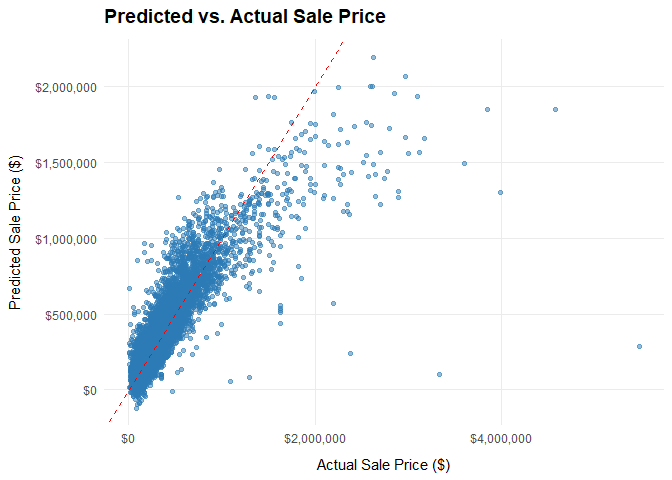

In [ ]:
# Create predicted vs. actual plot

pred_df <- cv_model_4$pred

# Plot Predicted vs Actual 
pred_v_act <- ggplot(pred_df, aes(x = obs, y = pred)) +
  geom_point(alpha = 0.5, color = "#2C7BB6") +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
  labs(
    title = "Predicted vs. Actual Sale Price",
    x = "Actual Sale Price ($)",
    y = "Predicted Sale Price ($)"
  ) +
  scale_x_continuous(labels = scales::dollar) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14, margin = margin(b = 10)),
    panel.grid.minor = element_blank(),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  )

pred_v_act

# Model Diagnostics

## Check Assumptions

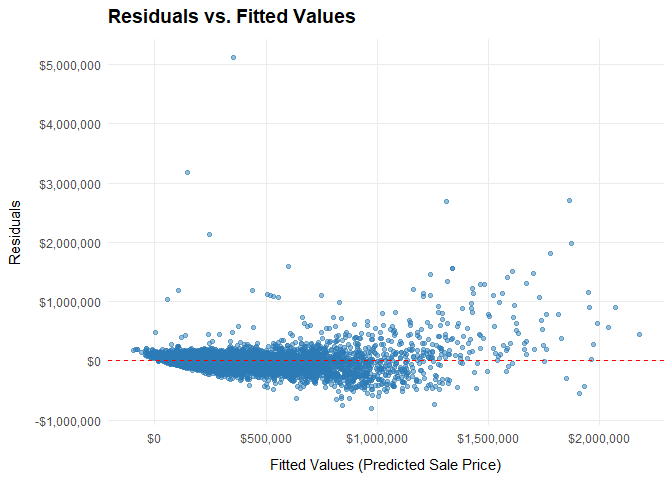

In [ ]:
resid_df <- data.frame(
  fitted = fitted(final_model),
  residuals = resid(final_model)
)

resid_v_fit <- ggplot(resid_df, aes(x = fitted, y = residuals)) +
  geom_point(alpha = 0.5, color = "#2C7BB6") +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Residuals vs. Fitted Values",
    x = "Fitted Values (Predicted Sale Price)",
    y = "Residuals"
  ) +
  scale_x_continuous(labels = scales::dollar) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14, margin = margin(b = 10)),
    panel.grid.minor = element_blank(),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  )

resid_v_fit

**Residuals vs Fitted Values:**

The residual plot shows that most residuals are centered around zero,
but the spread of residuals increases as the fitted values grow. This
“funnel-shaped” pattern suggests potential heteroskedasticity, meaning
the variance of errors may increase for higher-priced properties. While
the overall linearity assumption appears reasonable, the increasing
dispersion indicates that the model’s prediction error is not constant
across the price range.

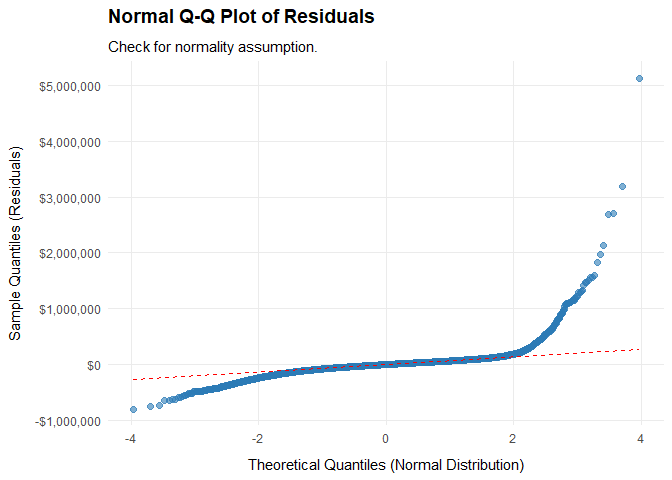

In [ ]:
resid_df <- data.frame(residuals = residuals(final_model))

# Q-Q Plot
qq_plot <- ggplot(resid_df, aes(sample = residuals)) +
  stat_qq(color = "#2C7BB6", alpha = 0.6, size = 2) +      
  stat_qq_line(color = "red", linetype = "dashed") +        
  labs(
    title = "Normal Q-Q Plot of Residuals",
    subtitle = "Check for normality assumption.",
    x = "Theoretical Quantiles (Normal Distribution)",
    y = "Sample Quantiles (Residuals)"
  ) +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::dollar) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14, margin = margin(b = 10)),
    plot.subtitle = element_text(size = 11),
    panel.grid.minor = element_blank(),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  )

qq_plot

**Normal Q–Q Plot:**

The Q–Q plot reveals that the residuals deviate from the reference line
in both tails, especially in the upper tail. This pattern indicates that
the residuals are right-skewed and not perfectly normally distributed.
The deviation is mainly driven by a small number of very high sale-price
observations, which pull the residual distribution upward. However,
moderate departures from normality are common in housing price data and
generally do not invalidate the model.

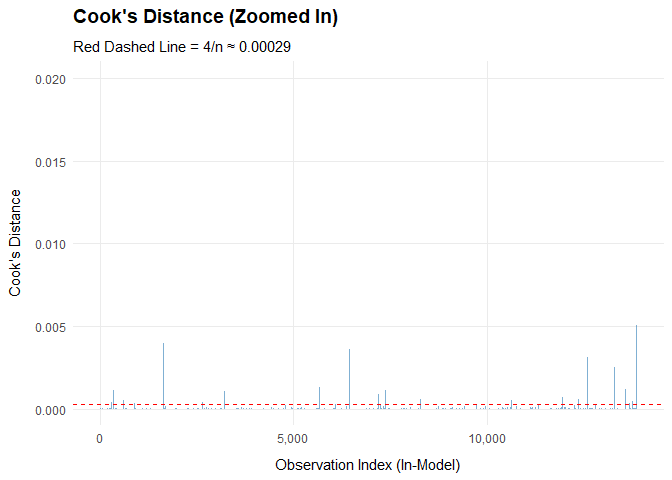

In [ ]:
cd <- cooks.distance(final_model)

used_row_idx <- as.integer(rownames(model.frame(final_model)))

cooks_df <- tibble(
  row_in_data  = used_row_idx,           
  row_in_model = seq_along(cd),          
  cooks_distance = as.numeric(cd)
)

n_used <- length(cd)
threshold <- 4 / n_used

cooks_plot <- ggplot(cooks_df, aes(x = row_in_model, y = cooks_distance)) +
  geom_bar(stat = "identity", fill = "#2C7BB6", alpha = 0.6) +
  geom_hline(yintercept = threshold, color = "red", linetype = "dashed") +
  coord_cartesian(ylim = c(0, 0.02)) +  
  labs(
    title = "Cook's Distance (Zoomed In)",
    subtitle = paste0("Red Dashed Line = 4/n ≈ ", round(threshold, 5)),
    x = "Observation Index (In-Model)",
    y = "Cook's Distance"
  ) +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::comma) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14, margin = margin(b = 10)),
    plot.subtitle = element_text(size = 11),
    panel.grid.minor = element_blank(),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  )

cooks_plot

In [ ]:
# Most influential
top_influential <- cooks_df %>%
  filter(cooks_distance > threshold) %>%
  arrange(desc(cooks_distance)) %>%
  slice_head(n = 10) %>%
  mutate(
    sale_price = final_data$sale_price[row_in_data]   
  ) %>%
  select(row_in_model, row_in_data, sale_price, cooks_distance)


top_influential

# A tibble: 10 × 4
   row_in_model row_in_data sale_price cooks_distance
          <int>       <int>      <dbl>          <dbl>
 1         6113        6113    3600000         0.197 
 2         6383        6383    5477901         0.129 
 3          198         198    3330400         0.0459
 4         8210        8211     480000         0.0454
 5         2496        2496    3995000         0.0395
 6        10469       10470     281000         0.0356
 7         7913        7914     330000         0.0325
 8         2620        2620    3000000         0.0283
 9         1921        1921     170000         0.0240
10         5439        5439    3850000         0.0233

**Cook’s Distance:**

The Cook’s distance plot shows that almost all observations have very
small influence values (below the 4/n threshold), indicating that the
model is not dominated by a few extreme points. A few cases exhibit
slightly higher Cook’s D values, suggesting the presence of mildly
influential outliers, but none appear to exert excessive leverage on the
regression coefficients.

# Detailed Discussion

-   What is your final model’s accuracy?

-   Which features matter most for Philadelphia prices?

-   Which neighborhoods are hardest to predict?

-   Equity concerns?

-   Limitations?

**Deliverable:**

Our final model achieves a cross-validated R² of 0.746, explaining
approximately 75% of the variance in Philadelphia residential sale
prices. The Mean Absolute Error (MAE) of 72,299 USD indicates that, on
average, predicted sale prices deviate from actual prices by roughly 29%
of the median home price (250,000 USD). However, the Root Mean Squared
Error (RMSE) of 138,257USD—nearly double the MAE—reveals that the model
struggles disproportionately with high-value properties. This
discrepancy, combined with residuals ranging from -817,701 USD to +5.1
million USD, reflects the outsized influence of luxury homes on overall
error. Diagnostic plots confirm these patterns: the Q-Q plot shows
deviation from normality in both tails (especially the upper tail),
while the residuals vs. fitted values plot exhibits a funnel-shaped
pattern indicating heteroskedasticity—prediction error variance
increases systematically for higher-priced properties. Despite these
issues, the median residual of 2,339 USD (near zero) suggests the
model’s predictions are generally unbiased for typical homes, and Cook’s
distance values remain well below concerning thresholds, indicating no
single observation dominates the model.

The model’s minimum and maximum residuals range from -817,701 USD to
+5.1 million USD, reflecting the outlier influence from luxury
properties. While simultaneously referencing the QQ Plot, the model
reflects two tails in the plot, but more in the positive region,
indicating the model is not 100% normal. However, the residual
distribution with the median residual of 2,339 USD is fairly close to 0,
meaning the model predictions are generally centered about sale prices
with limited bias in sale prediction. It is imperative to keep in mind
that in the residuals vs fitted values plot, the increase of
observations fanning-out as the predicted sale price value increases
indicates the existence of heteroskedasticity between some variables.

Structural features appear to be most significant to our model: the
logged livable square footage variable’s $\beta$ coefficient is 259,826
USD (1% increase in square footage indicates a 2,598 sale price
increase). The garage’s $\beta$ coefficient is 77,433 USD, so for every
additional garage, the predicted price increases as such. The number of
fireplaces per household’s $\beta$ coefficient indicates an increase in
predicted house price of 88,252 USD. As the number of bathrooms
increase, the estimated home price increases by 43,771 USD. Some spatial
features positively influenced our model: one SEPTA area per half mile
increases the housing value by 1,426 USD. The interaction between SEPTA
areas per half mile and the distance from Center City by miles has a
coefficient of -331, indicating as the distance from CC increases, being
near SEPTA becomes more positive (or matters more in the suburbs).
Regarding the interaction between the amneity index and the distance
from CC by miles has a coefficient of -1,923 - in that walkability to
amenities is more influential downtown versus the suburban areas.

Neighborhood fixed effects show drastic varaible between neghiborhoods
like Old City ($\beta$ = +436,996 USD), University City ($\beta$ = +
593, 848 USD) and Rittenhouse (($\beta$ = + 421,622 USD)

# External Resources

### Relevant Readings

-   

### Artificial Intelligence

-   Claude: For code debugging in data cleaning and visualizations.

-   Chat GPT: For code debugging in data cleaning and visualizations.